# **Using Wavelet Decomposition 3 Level without preprocessing**

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S27 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
E

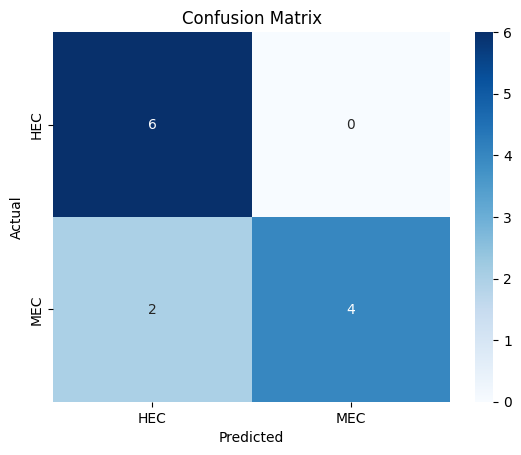

📌 Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.67      0.80         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12

📌 Number of Training Samples: 46
📌 Number of Testing Samples: 12


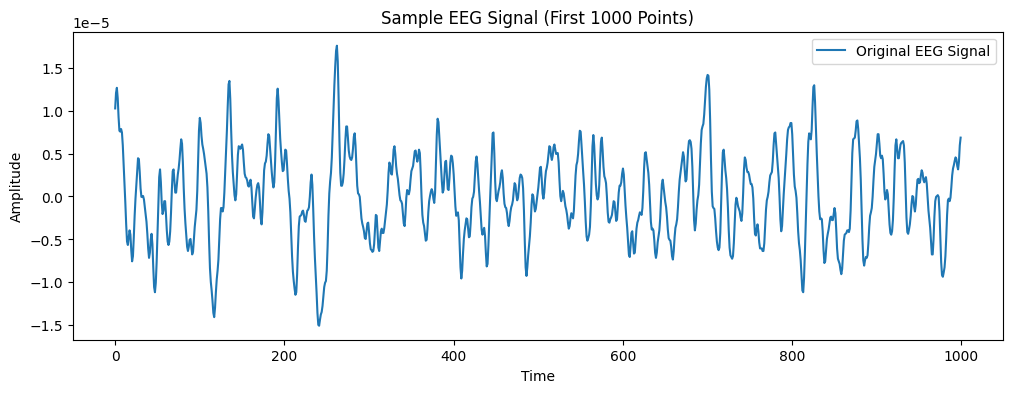

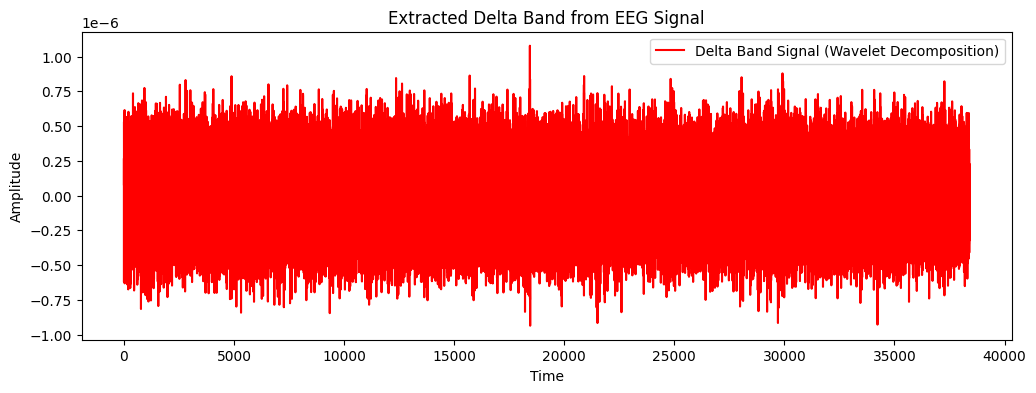

In [1]:
import os
import numpy as np
import mne
import pywt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define dataset path (update this with your actual EEG dataset path)
dataset_path = "/kaggle/input/mdd-dataset/MDD Dataset"
folders = ["HEC", "MEC"]

# Function to extract Delta band (0.5 - 4 Hz) from wavelet decomposition
def extract_delta_band(eeg_signal, wavelet='db4', level=3):
    """Extract only Delta band (0.5 - 4 Hz) from wavelet decomposition."""
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)
    delta_coeffs = coeffs[-1]  # Lowest frequency band (Delta)
    return delta_coeffs, coeffs

# Function to extract statistical features from wavelet coefficients
def extract_features(coeffs):
    """Extract 12 statistical features from Delta coefficients."""
    return [
        np.mean(coeffs),                # Mean
        np.var(coeffs),                 # Variance
        stats.skew(coeffs),             # Skewness
        stats.kurtosis(coeffs),         # Kurtosis
        np.sum(np.abs(coeffs)),         # Energy
        np.max(coeffs) - np.min(coeffs),# Peak-to-Peak
        np.median(coeffs),              # Median
        stats.iqr(coeffs),              # Interquartile Range
        np.std(coeffs),                 # Standard Deviation
        -np.sum(coeffs * np.log2(np.abs(coeffs) + 1e-10)),  # Shannon Entropy
        np.sum(coeffs**2),              # Signal Power
        np.log1p(np.sum(coeffs**2))     # Log Energy
    ]

# Prepare dataset
X, y = [], []
sample_signal = None  # To visualize one sample EEG signal
sample_delta = None   # To visualize its wavelet decomposition

# Process each file in HEC & MEC
for label, folder in enumerate(folders):  # HEC -> 0, MEC -> 1
    folder_path = os.path.join(dataset_path, folder)

    for file in os.listdir(folder_path):
        if file.endswith(".edf"):
            file_path = os.path.join(folder_path, file)
            
            # Load EEG data
            raw = mne.io.read_raw_edf(file_path, preload=True)
            eeg_data = raw.get_data()  # Shape: (channels, time)
            
            # Extract first EEG channel
            eeg_signal = eeg_data[0]  

            # Extract Delta band coefficients
            delta_coeffs, all_coeffs = extract_delta_band(eeg_signal)

            # Save first sample for visualization
            if sample_signal is None:
                sample_signal = eeg_signal
                sample_delta = delta_coeffs

            # Compute statistical features
            features = extract_features(delta_coeffs)

            # Store features & labels
            X.append(features)
            y.append(label)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier (Random Forest)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy of Random Forest: {acc * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["HEC", "MEC"], yticklabels=["HEC", "MEC"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("📌 Classification Report:\n", classification_report(y_test, y_pred))

# Show number of samples used for training & testing
print(f"📌 Number of Training Samples: {len(X_train)}")
print(f"📌 Number of Testing Samples: {len(X_test)}")

# Plot original EEG signal
plt.figure(figsize=(12, 4))
plt.plot(sample_signal[:1000], label="Original EEG Signal")
plt.legend()
plt.title("Sample EEG Signal (First 1000 Points)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Plot extracted Delta band signal
plt.figure(figsize=(12, 4))
plt.plot(sample_delta, label="Delta Band Signal (Wavelet Decomposition)", color='r')
plt.legend()
plt.title("Extracted Delta Band from EEG Signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


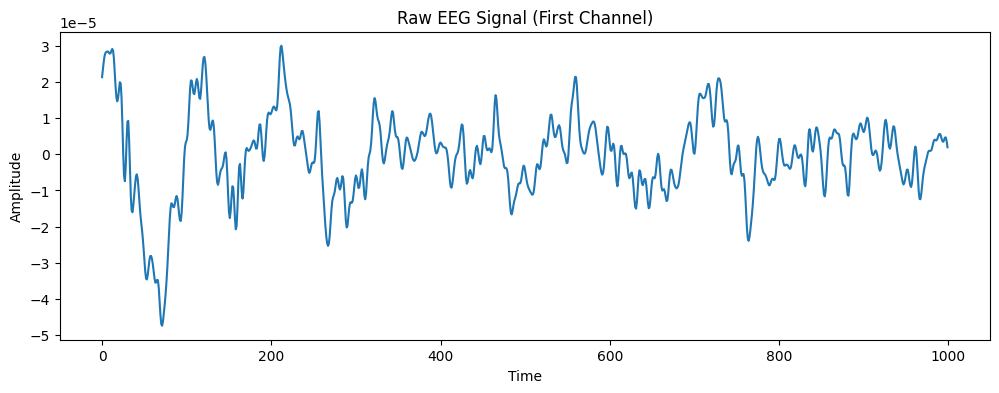

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(eeg_signal[:1000])  # Plot first 1000 time points
plt.title("Raw EEG Signal (First Channel)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


# **Level 5 decomposition using db4 linear features**

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S27 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
E

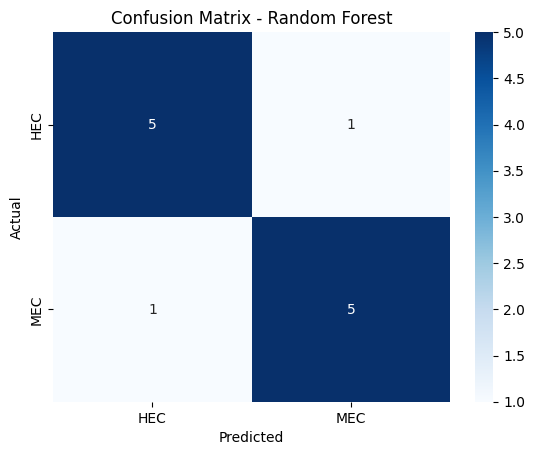

📌 Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       0.83      0.83      0.83         6

    accuracy                           0.83        12
   macro avg       0.83      0.83      0.83        12
weighted avg       0.83      0.83      0.83        12

✅ SVM Accuracy: 41.67%


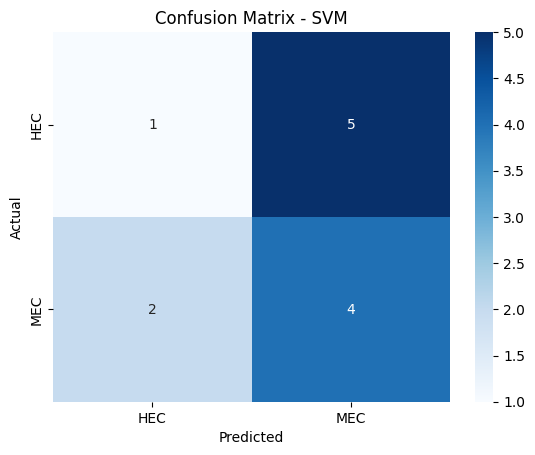

📌 Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.33      0.17      0.22         6
           1       0.44      0.67      0.53         6

    accuracy                           0.42        12
   macro avg       0.39      0.42      0.38        12
weighted avg       0.39      0.42      0.38        12

✅ KNN Accuracy: 75.00%


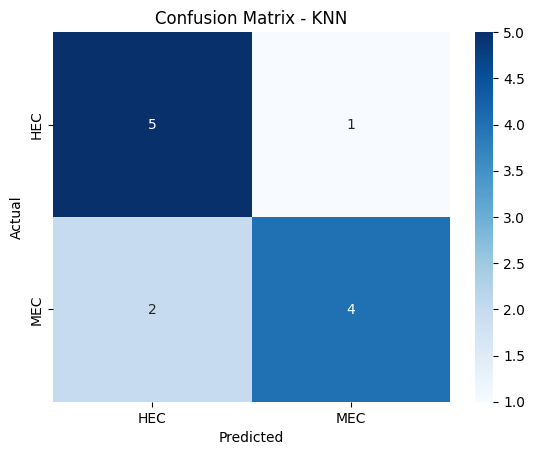

📌 Classification Report for KNN:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.80      0.67      0.73         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

✅ XGBoost Accuracy: 75.00%


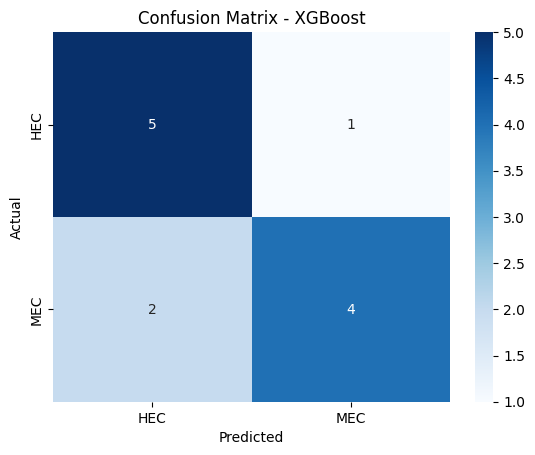

📌 Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.80      0.67      0.73         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

[LightGBM] [Info] Number of positive: 24, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

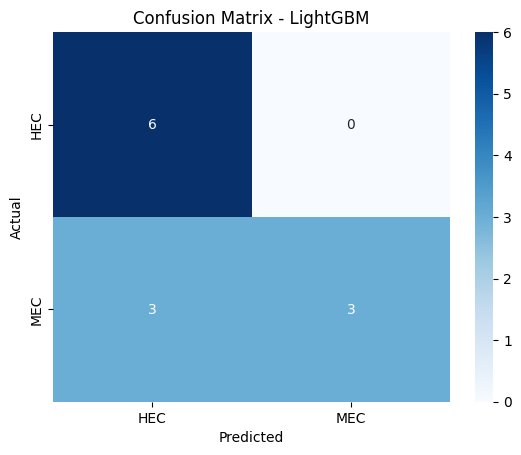

📌 Classification Report for LightGBM:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       1.00      0.50      0.67         6

    accuracy                           0.75        12
   macro avg       0.83      0.75      0.73        12
weighted avg       0.83      0.75      0.73        12

✅ Naive Bayes Accuracy: 33.33%


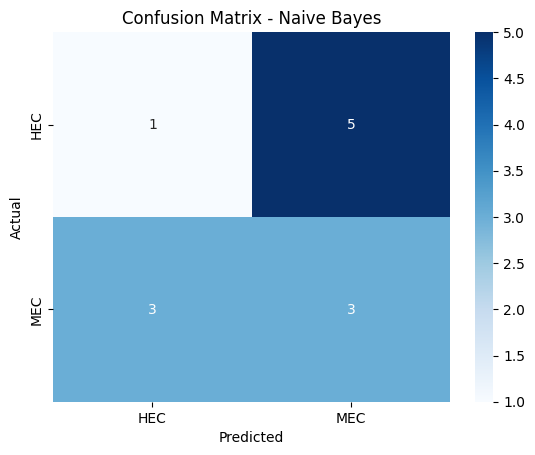

📌 Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       0.38      0.50      0.43         6

    accuracy                           0.33        12
   macro avg       0.31      0.33      0.31        12
weighted avg       0.31      0.33      0.31        12

[LightGBM] [Info] Number of positive: 24, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 85
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

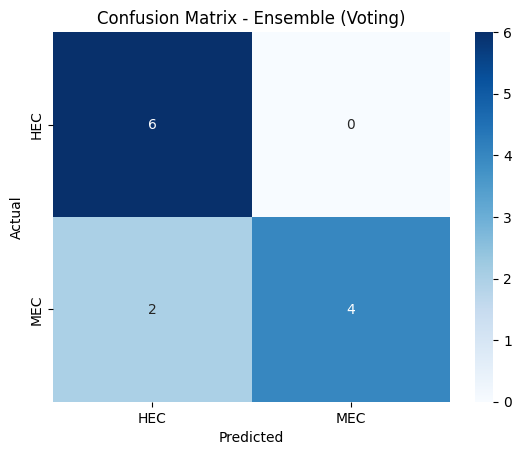

📌 Classification Report for Ensemble (Voting):
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         6
           1       1.00      0.67      0.80         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12

📌 Number of Training Samples: 46
📌 Number of Testing Samples: 12


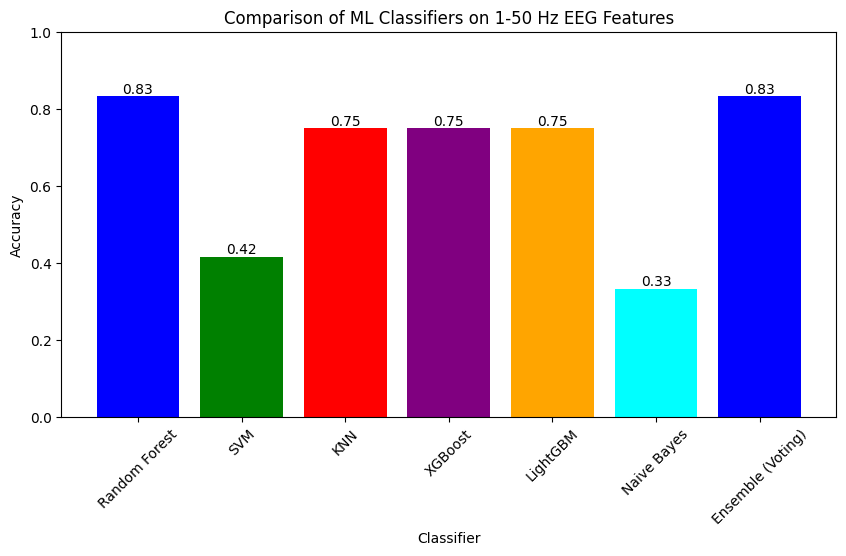

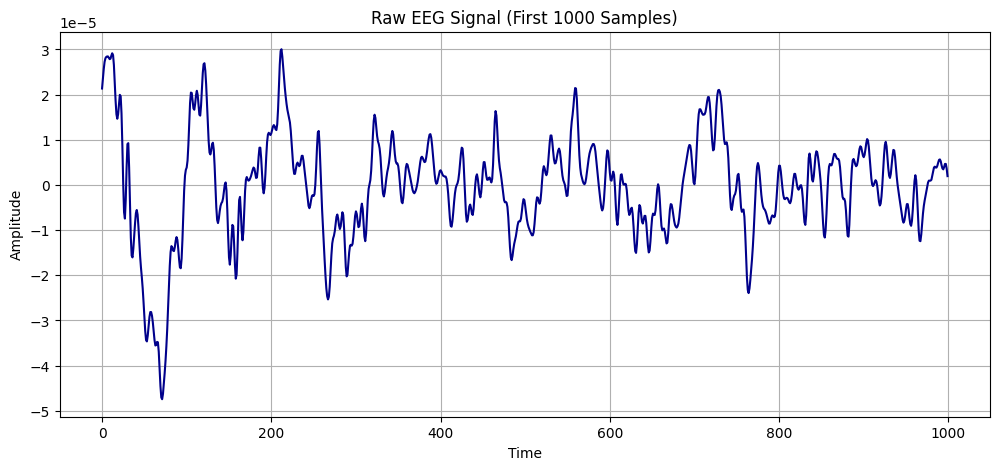

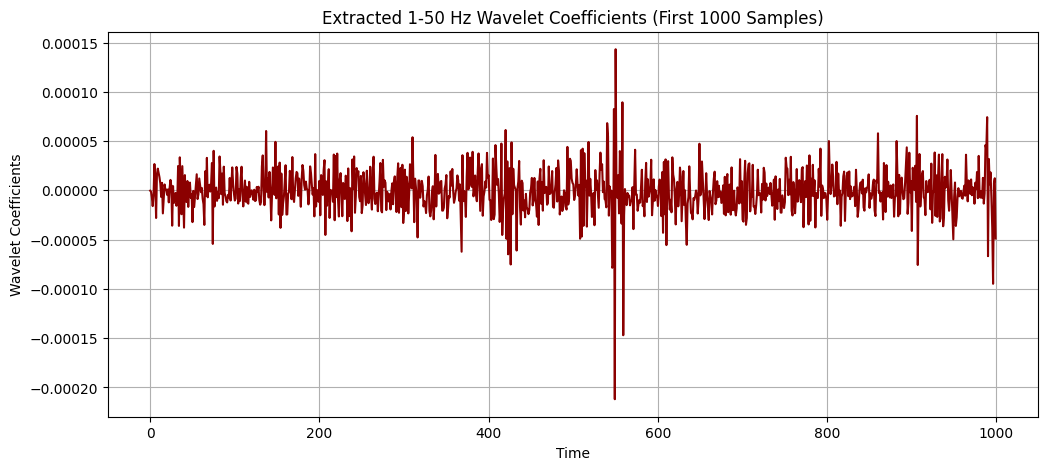

In [3]:
import os
import numpy as np
import mne
import pywt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Define dataset path (Update with your EEG dataset path)
dataset_path = "/kaggle/input/mdd-dataset/MDD Dataset"
folders = ["HEC", "MEC"]  # HEC -> Healthy, MEC -> Depressed

# Function to extract 1 Hz - 50 Hz band using wavelet decomposition
def extract_band_1_50_hz(eeg_signal, wavelet='db4', level=5):
    """Extract 1 Hz - 50 Hz frequency components using wavelet decomposition."""
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)

    # Approximate frequency bands based on decomposition levels
    bands = {
        "D1": (25-50),  # High-frequency details (25-50 Hz)
        "D2": (12-25),  # 12-25 Hz
        "D3": (6-12),   # 6-12 Hz
        "D4": (3-6),    # 3-6 Hz
        "D5": (1-3)     # 1-3 Hz
    }

    # Extract coefficients corresponding to 1 Hz - 50 Hz
    selected_coeffs = coeffs[1:6]  # Taking D1 to D5 only
    combined_coeffs = np.concatenate(selected_coeffs)  # Merge bands

    return combined_coeffs  # Final signal representing 1-50 Hz range

# Function to compute statistical features
def extract_features(filtered_coeffs):
    """Extract mean, std, skewness, kurtosis, and entropy as features."""
    mean_val = np.mean(filtered_coeffs)
    std_val = np.std(filtered_coeffs)
    skewness = stats.skew(filtered_coeffs)
    kurtosis = stats.kurtosis(filtered_coeffs)
    entropy_val = -np.sum(filtered_coeffs * np.log2(np.abs(filtered_coeffs) + 1e-10))

    return [mean_val, std_val, skewness, kurtosis, entropy_val]

# Prepare dataset
X, y = [], []

# Process each file in HEC & MEC
for label, folder in enumerate(folders):  # HEC -> 0, MEC -> 1
    folder_path = os.path.join(dataset_path, folder)

    for file in os.listdir(folder_path):
        if file.endswith(".edf"):
            file_path = os.path.join(folder_path, file)
            
            # Load EEG data
            raw = mne.io.read_raw_edf(file_path, preload=True)
            eeg_data = raw.get_data()  # Shape: (channels, time)
            
            # Extract first EEG channel
            eeg_signal = eeg_data[0]  

            # Extract 1-50 Hz band
            filtered_coeffs = extract_band_1_50_hz(eeg_signal)

            # Compute features
            features = extract_features(filtered_coeffs)

            # Store features & labels
            X.append(features)
            y.append(label)

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "Naive Bayes": GaussianNB()
}

# Ensemble Model (Voting Classifier)
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', classifiers["Random Forest"]),
        ('svm', classifiers["SVM"]),
        ('xgb', classifiers["XGBoost"]),
        ('lgbm', classifiers["LightGBM"])
    ],
    voting='hard'
)

# Add ensemble model to classifiers dictionary
classifiers["Ensemble (Voting)"] = ensemble_model

# Train & evaluate classifiers
accuracies = {}

for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies[clf_name] = acc
    print(f"✅ {clf_name} Accuracy: {acc * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["HEC", "MEC"], yticklabels=["HEC", "MEC"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {clf_name}")
    plt.show()

    # Print classification report
    print(f"📌 Classification Report for {clf_name}:\n{classification_report(y_test, y_pred)}")

# Show number of training & testing samples
print(f"📌 Number of Training Samples: {len(X_train)}")
print(f"📌 Number of Testing Samples: {len(X_test)}")

# Plot classifier accuracy comparison
plt.figure(figsize=(10, 5))
bars = plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'red', 'purple', 'orange', 'cyan'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Comparison of ML Classifiers on 1-50 Hz EEG Features")
plt.ylim(0, 1)

# Annotate bar values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

# Plot original EEG signal (first 1000 samples)
plt.figure(figsize=(12, 5))
plt.plot(eeg_signal[:1000], color='darkblue')  
plt.title("Raw EEG Signal (First 1000 Samples)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Plot extracted 1-50 Hz wave
plt.figure(figsize=(12, 5))
plt.plot(filtered_coeffs[:1000], color='darkred')  
plt.title("Extracted 1-50 Hz Wavelet Coefficients (First 1000 Samples)")
plt.xlabel("Time")
plt.ylabel("Wavelet Coefficients")
plt.grid()
plt.show()


# **Using Different Wavelet Coefficent**

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S27 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


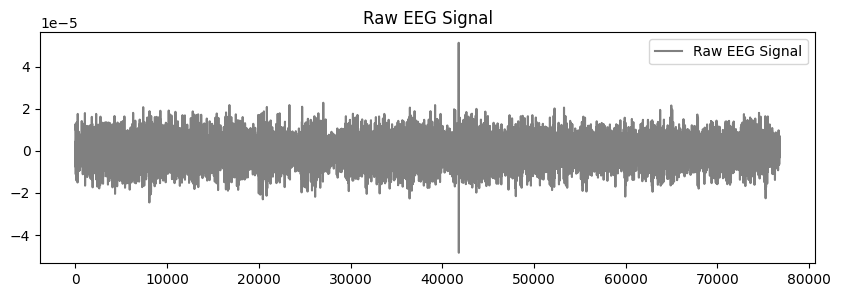

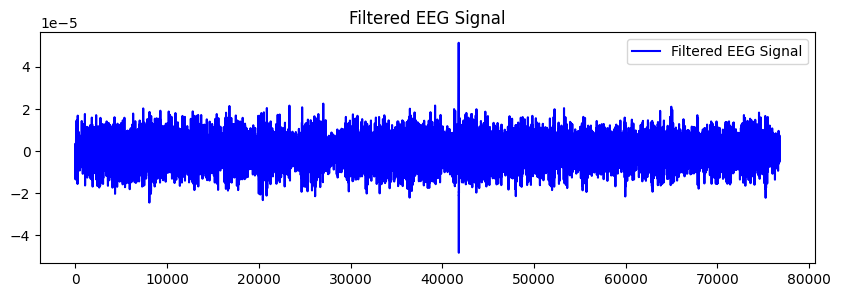

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...


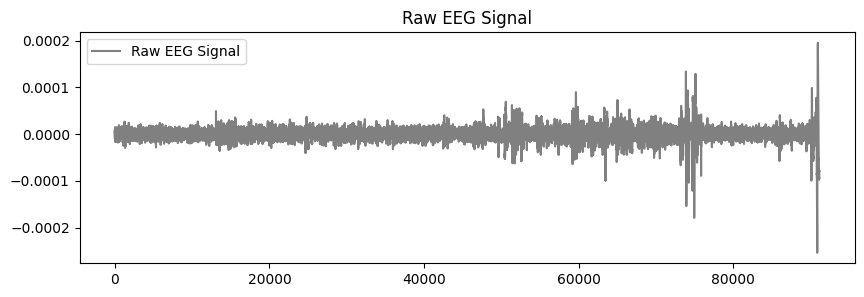

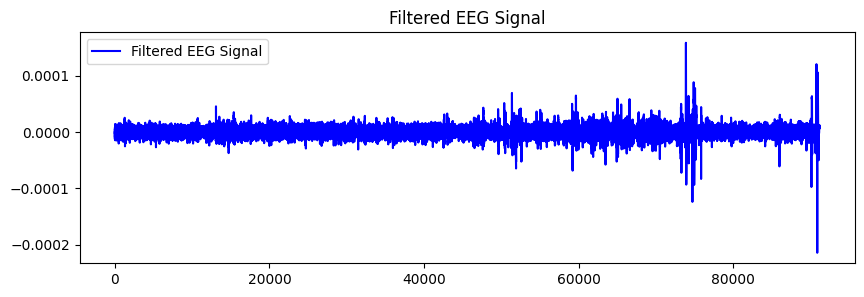

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


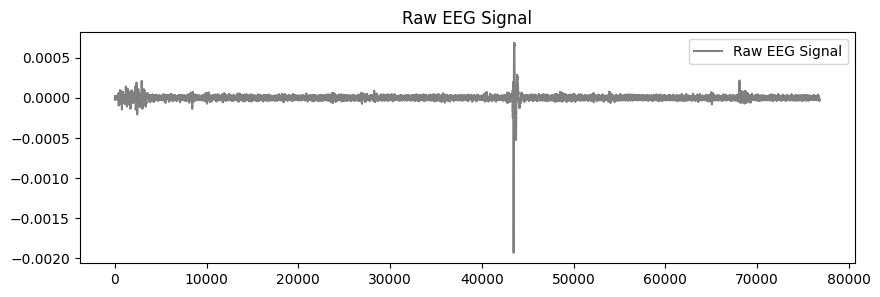

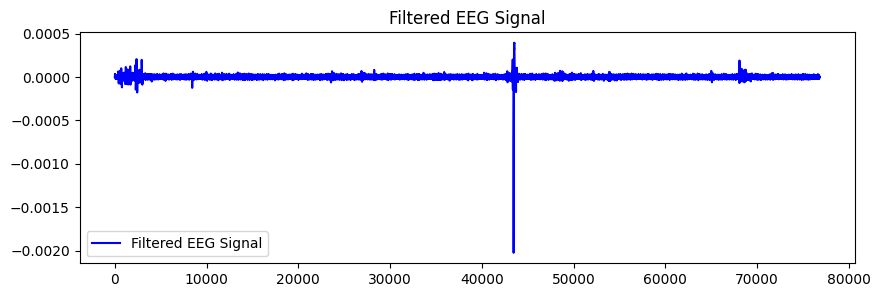

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


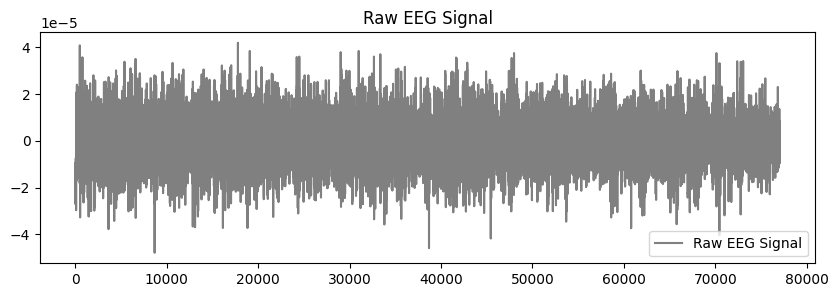

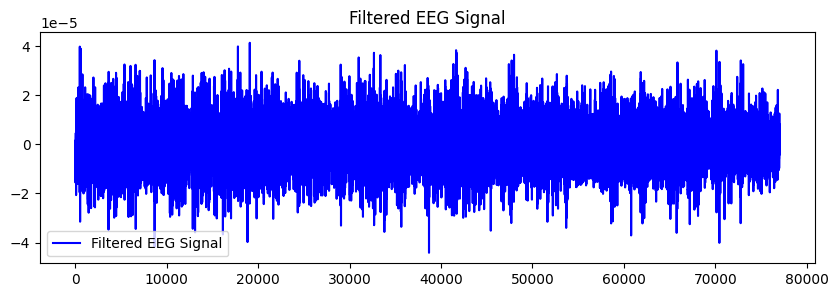

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...


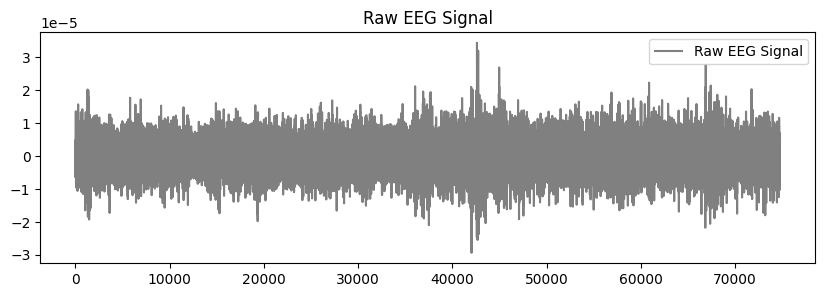

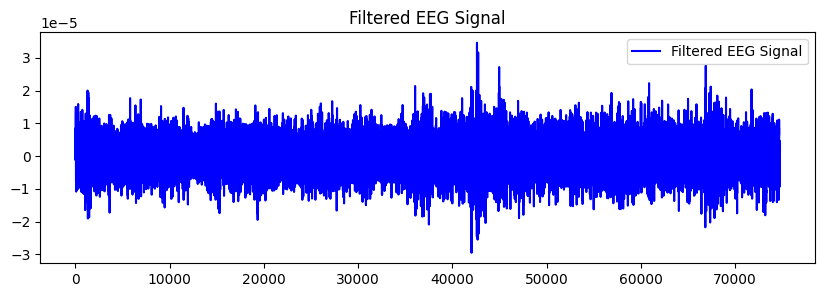

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


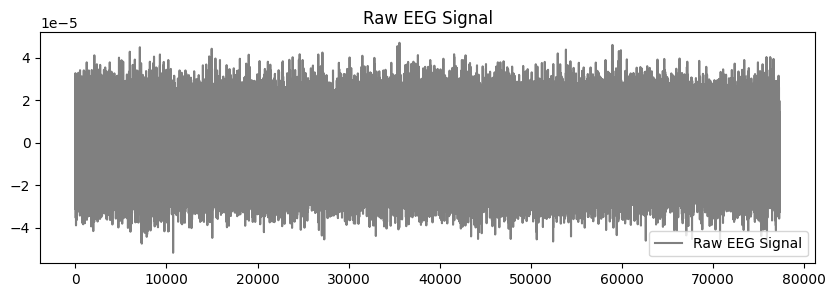

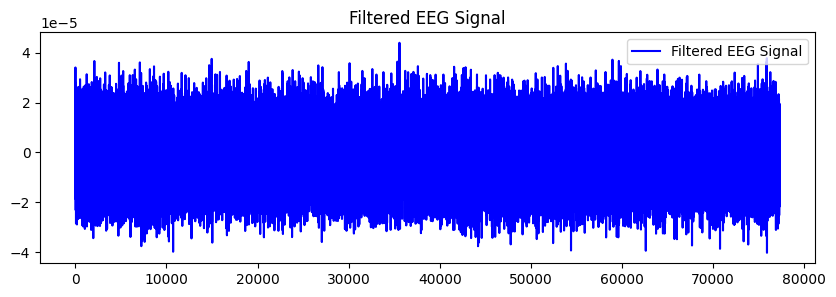

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S9 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


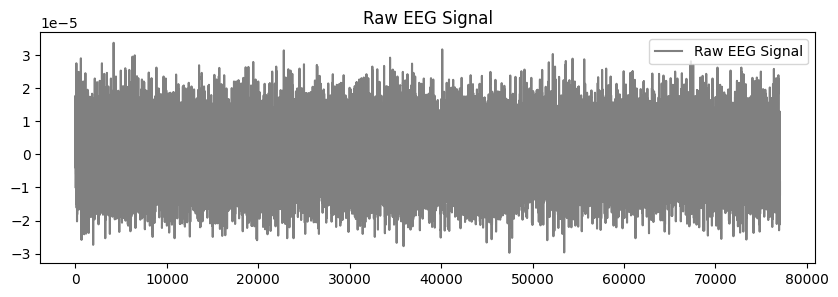

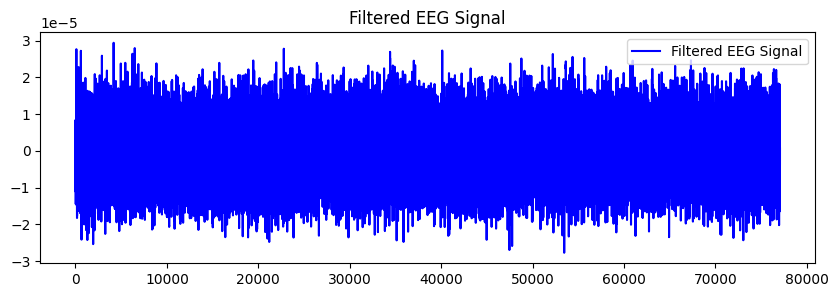

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S21 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


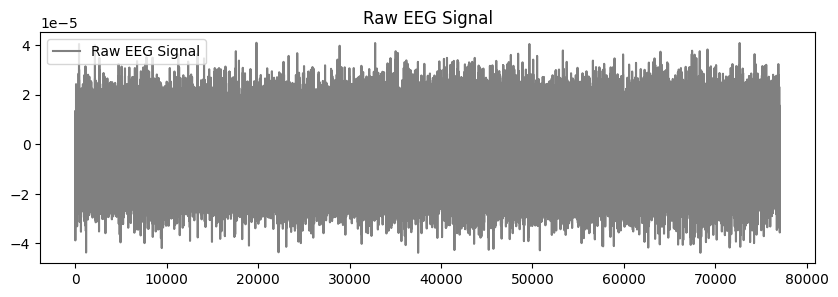

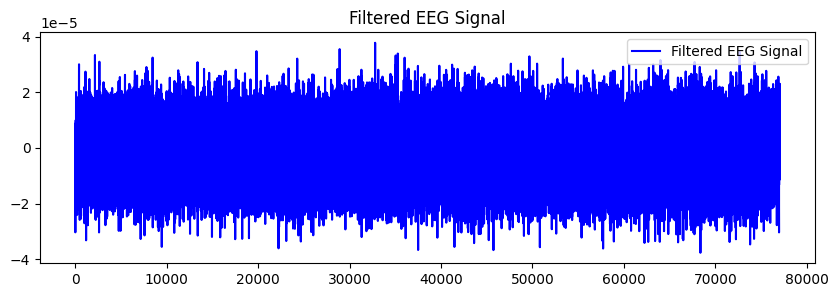

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S17 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 79103  =      0.000 ...   308.996 secs...


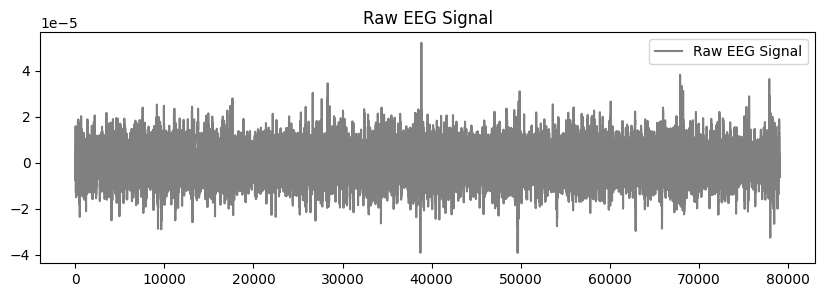

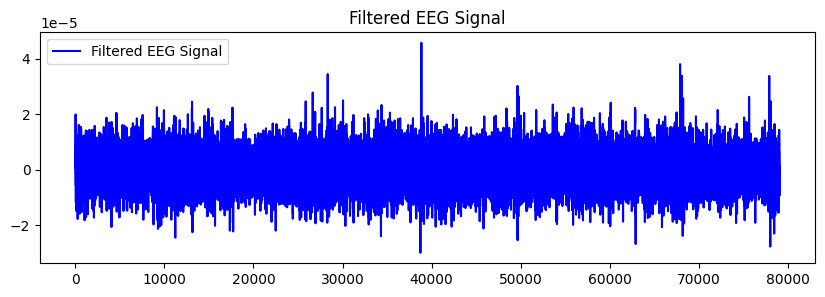

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S30 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


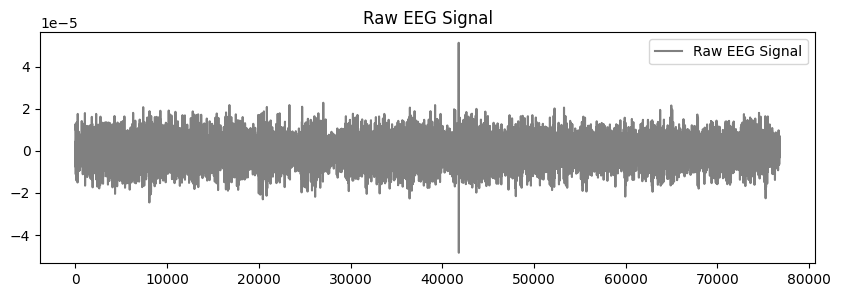

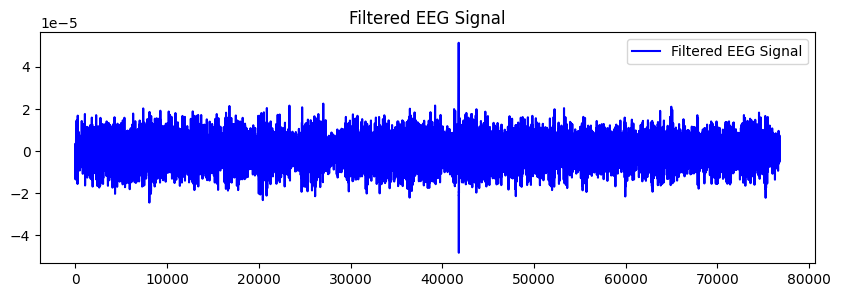

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S10 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96255  =      0.000 ...   375.996 secs...


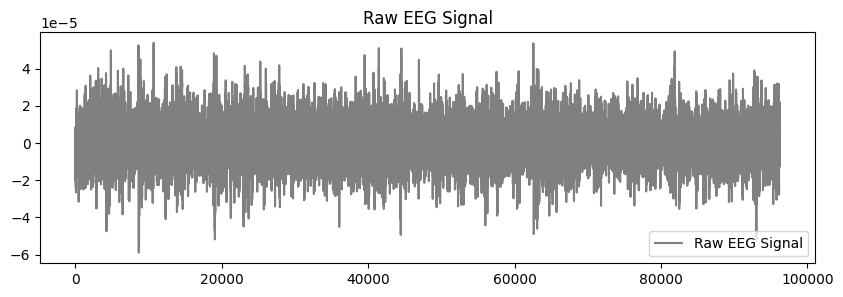

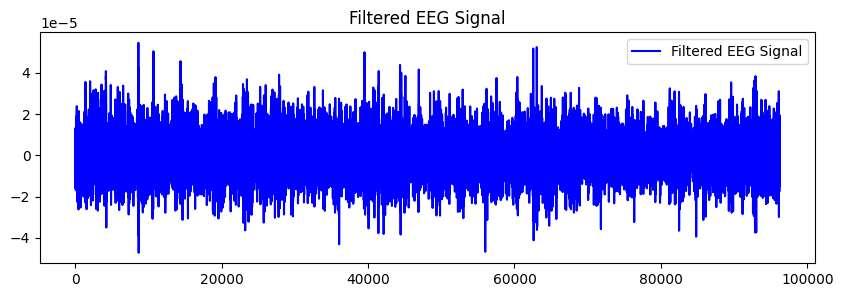

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S26 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


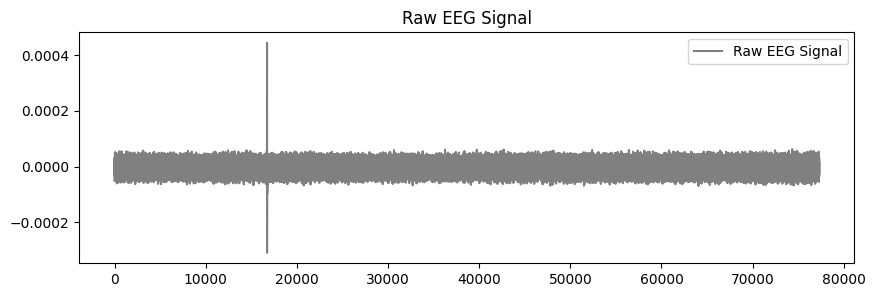

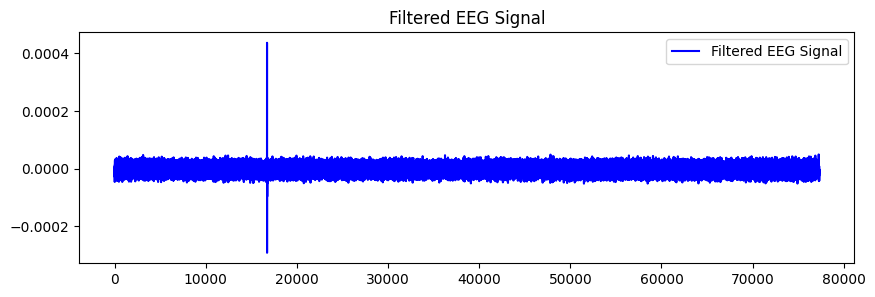

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S4 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


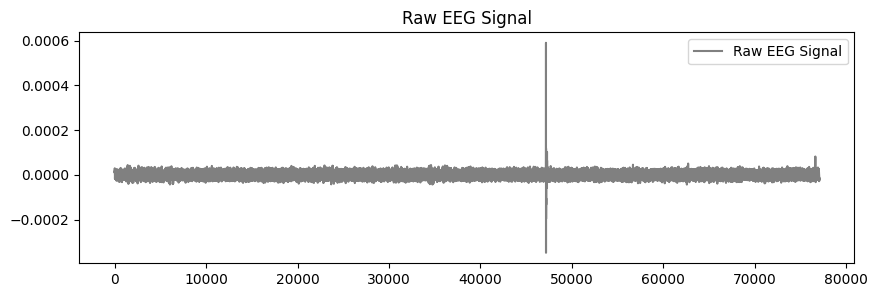

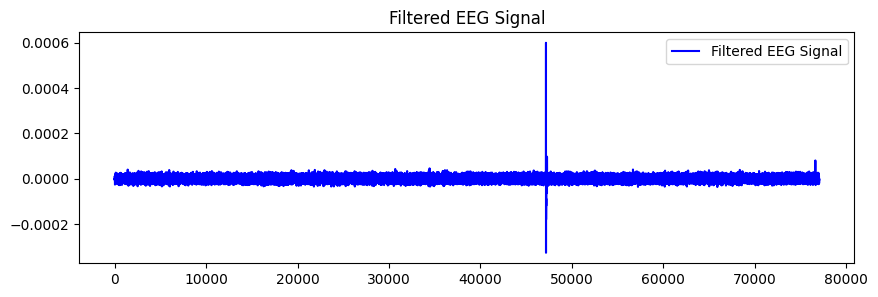

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S28 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


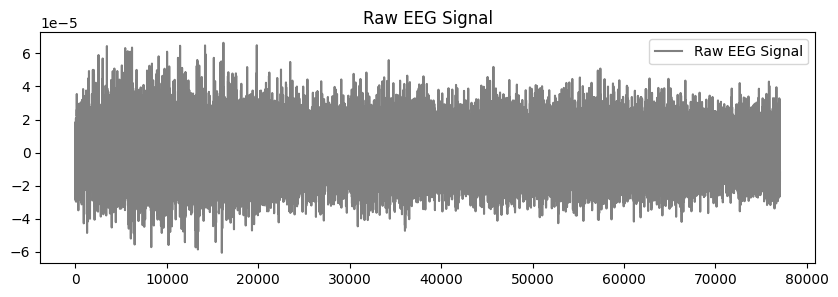

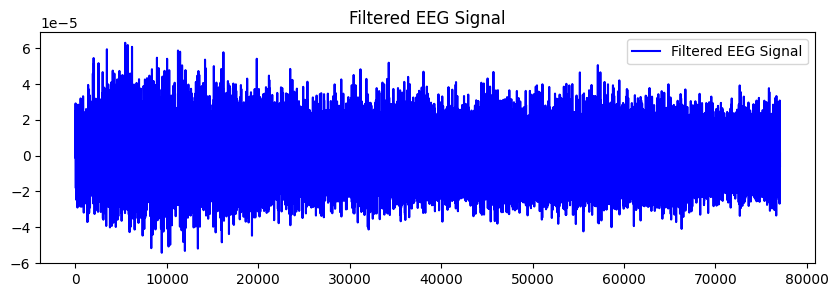

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S13 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


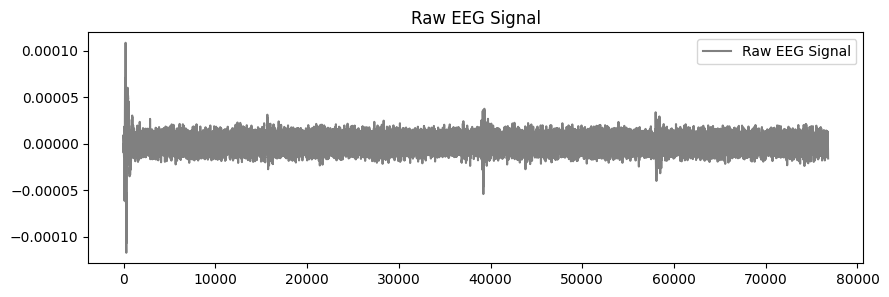

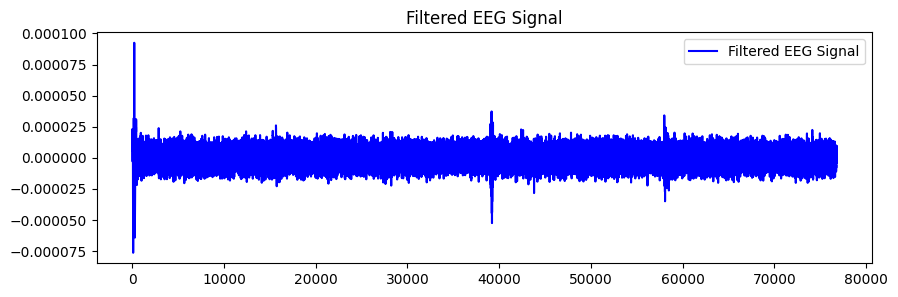

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S6 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


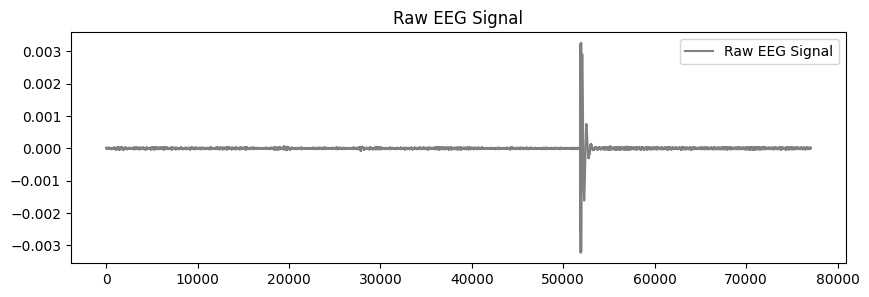

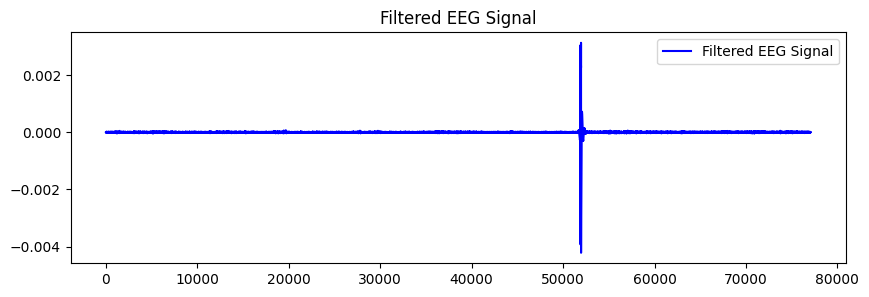

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S8 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


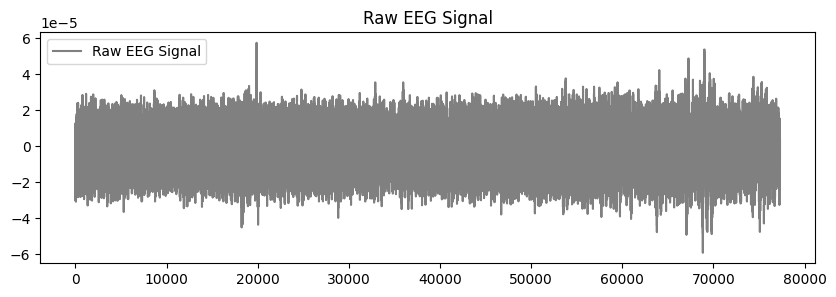

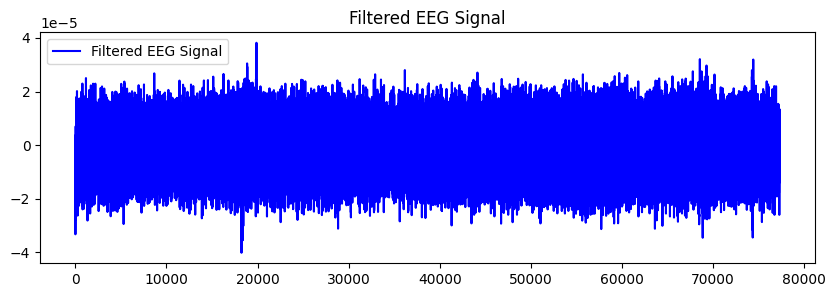

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S11 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


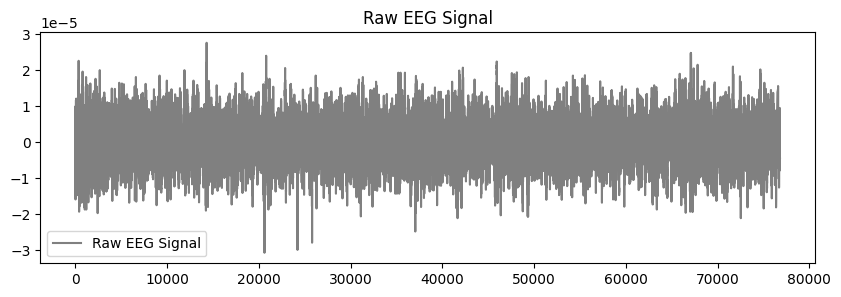

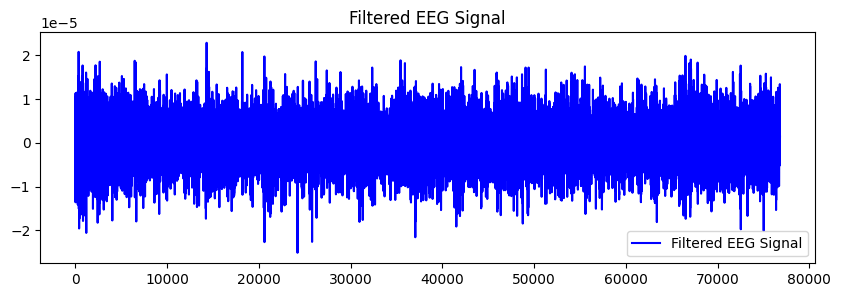

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S20 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 78591  =      0.000 ...   306.996 secs...


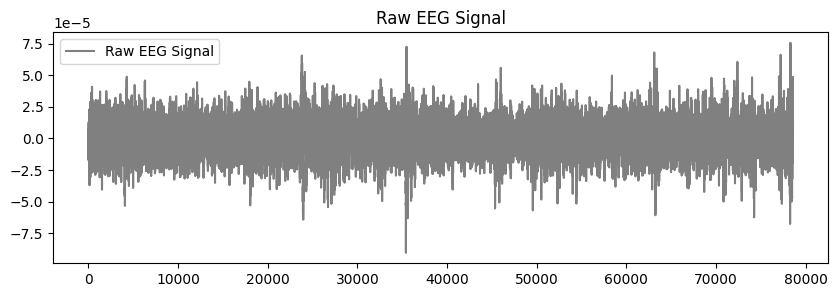

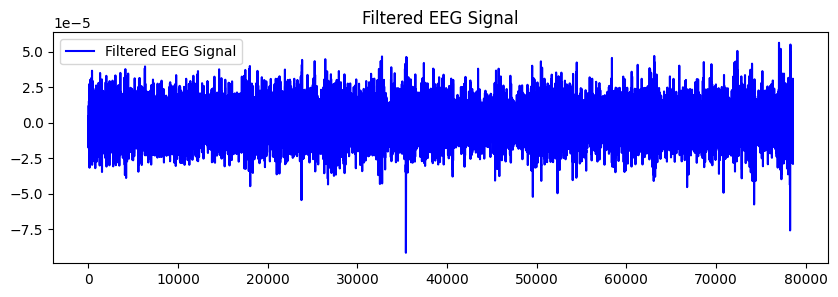

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S25 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


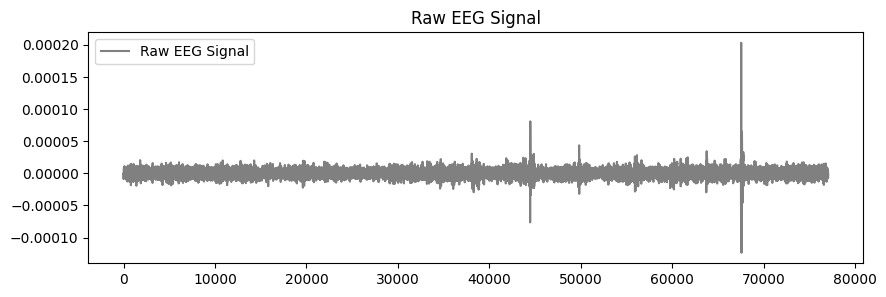

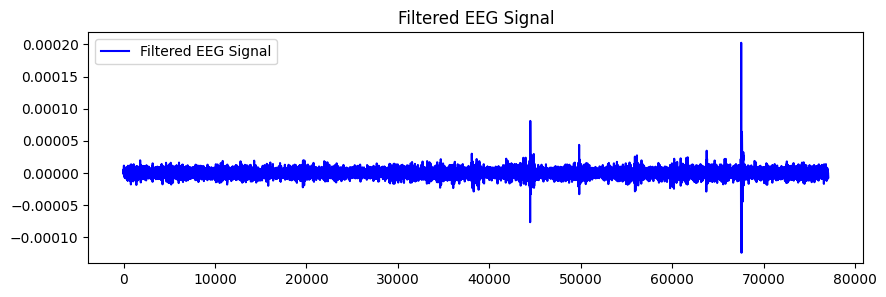

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S1 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


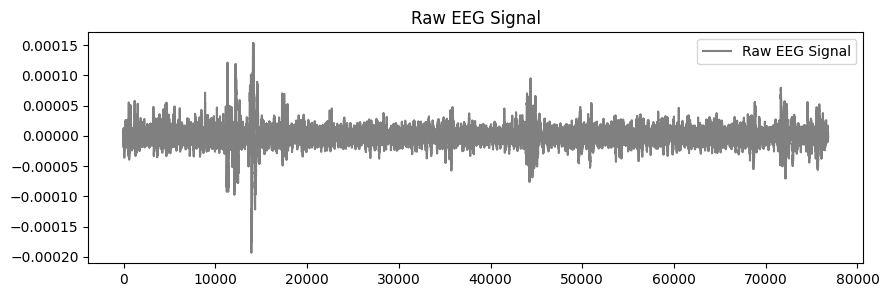

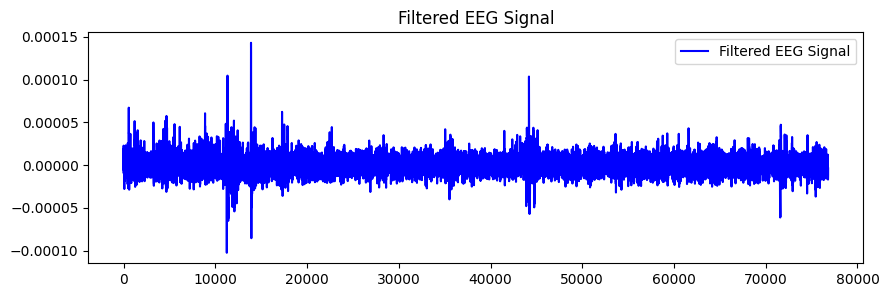

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S23 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


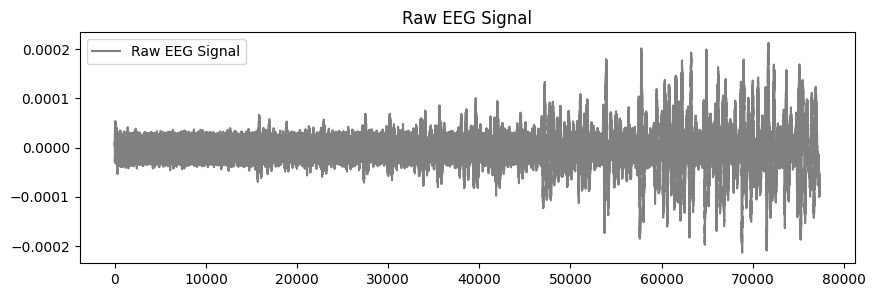

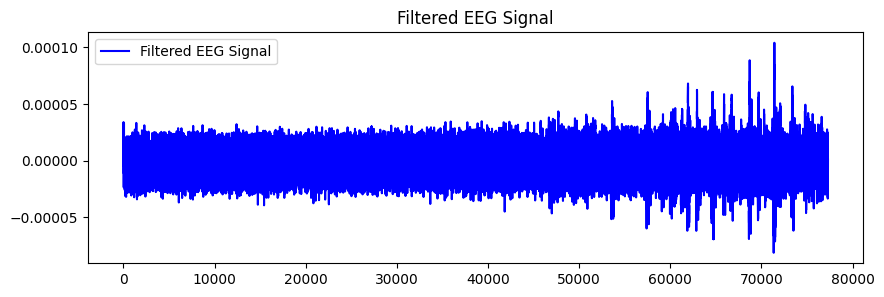

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S29 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77567  =      0.000 ...   302.996 secs...


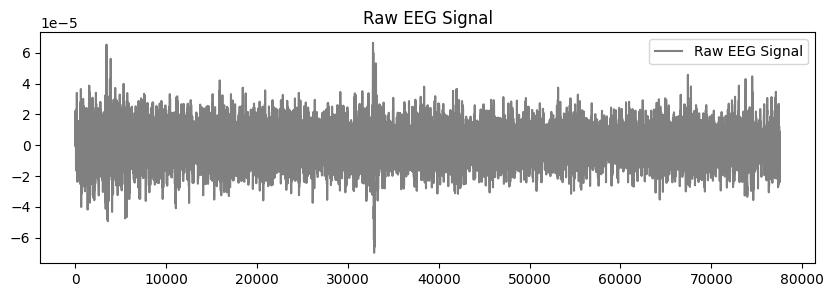

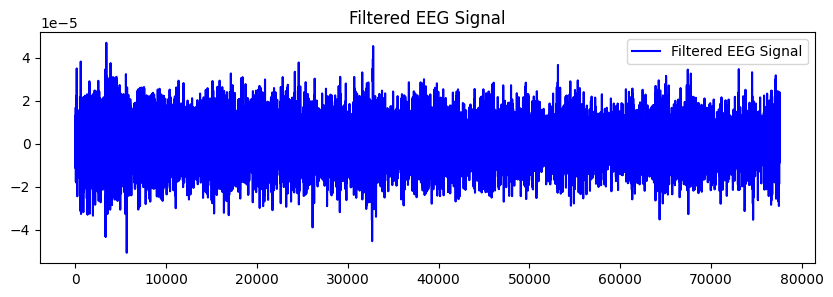

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S22 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


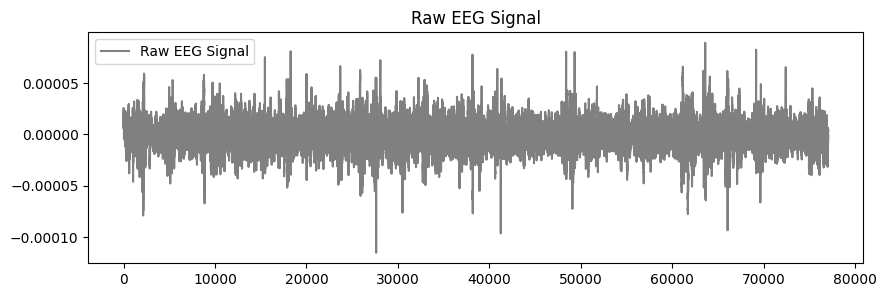

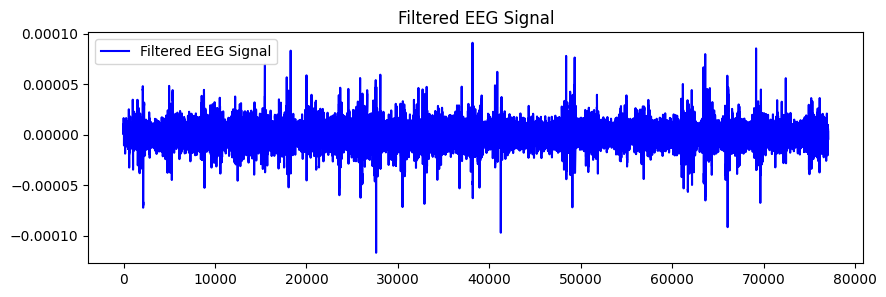

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S15 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


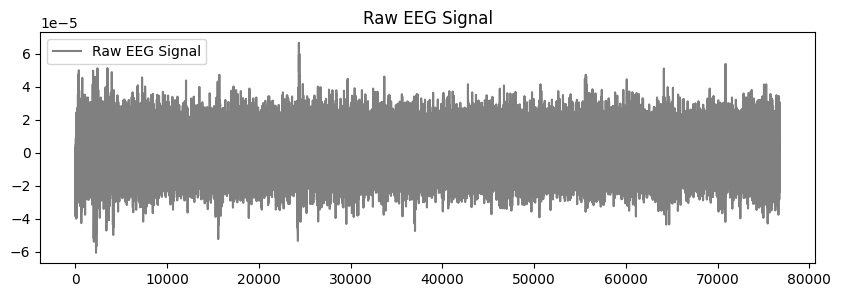

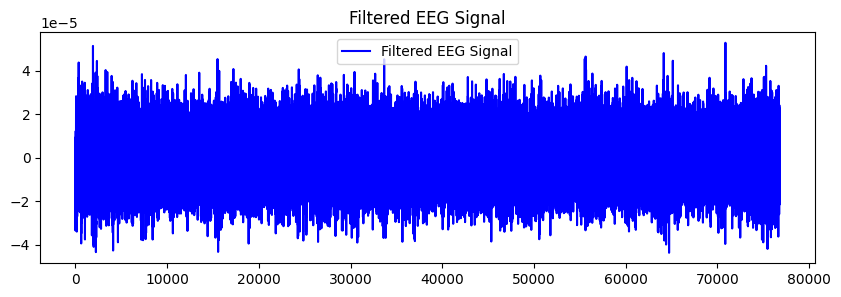

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S2 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


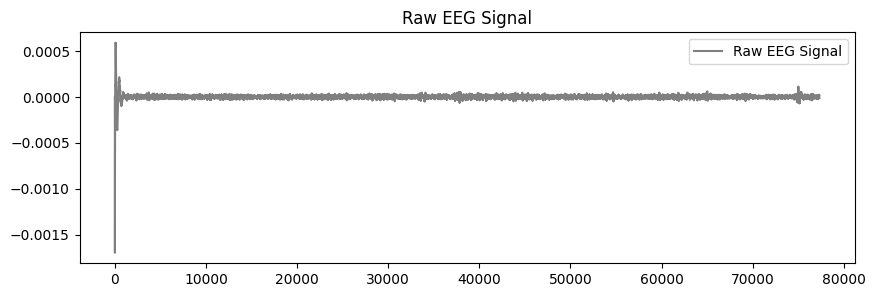

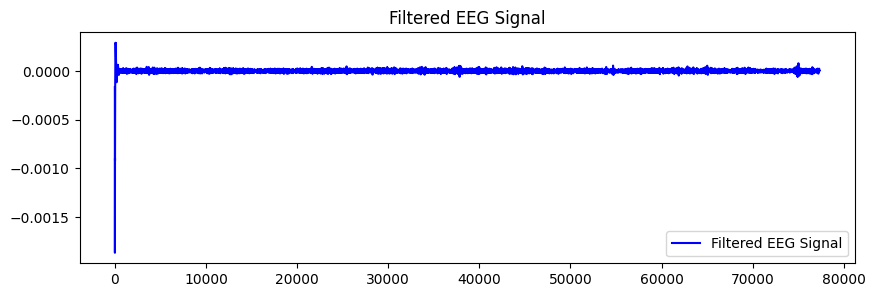

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S5 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77567  =      0.000 ...   302.996 secs...


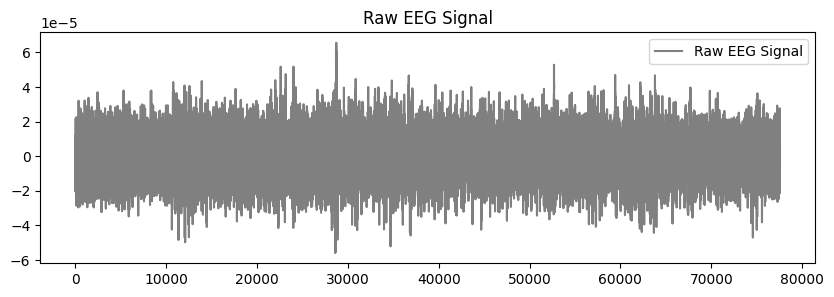

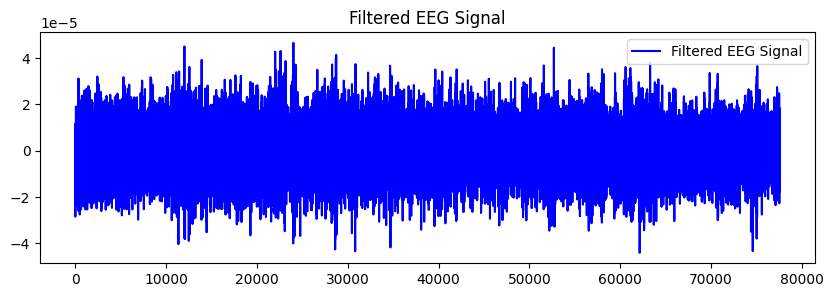

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S24 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...


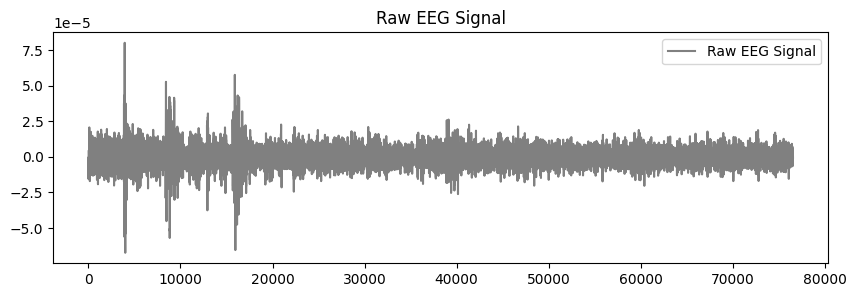

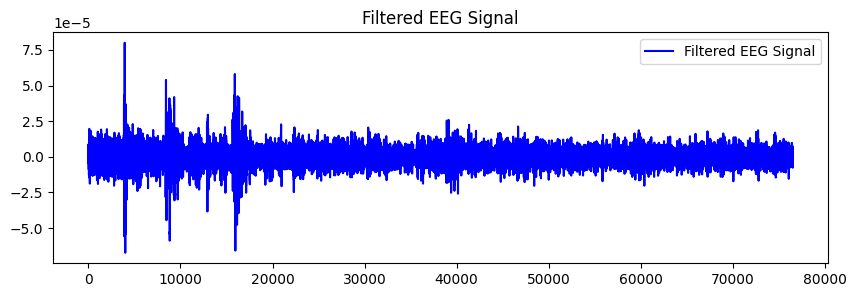

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 46079  =      0.000 ...   179.996 secs...


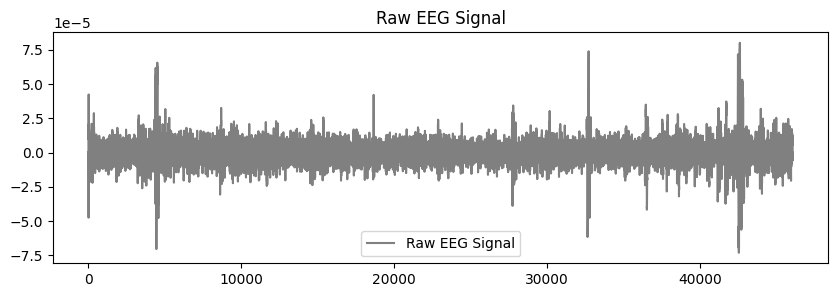

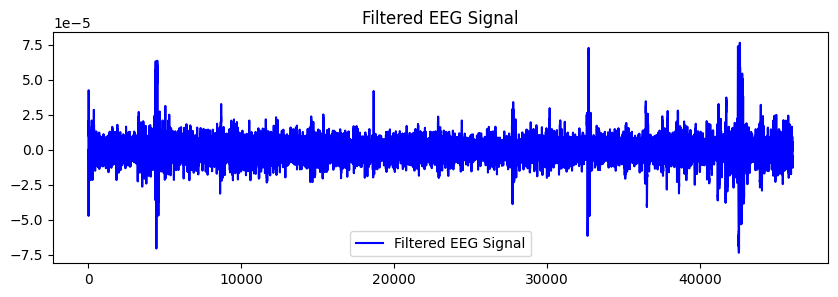

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S22 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...


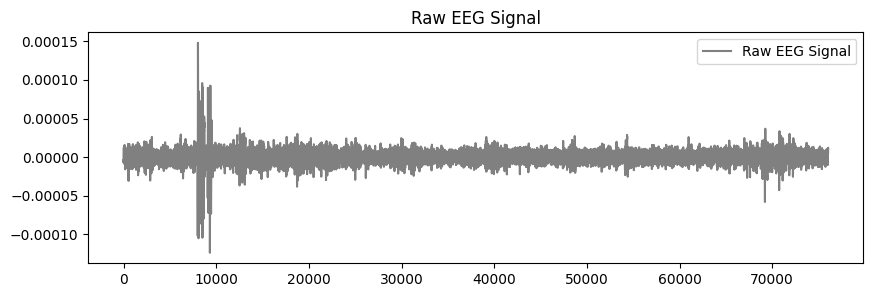

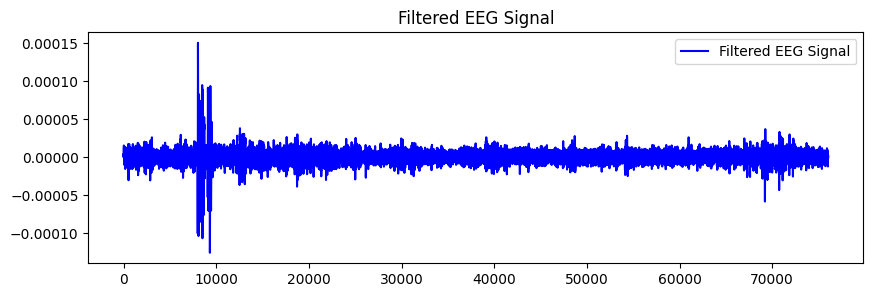

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S31 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


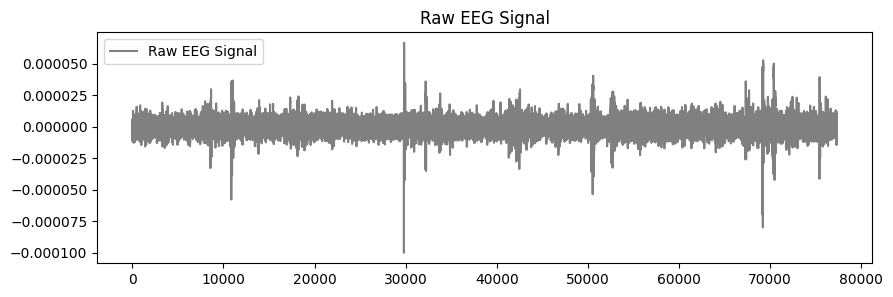

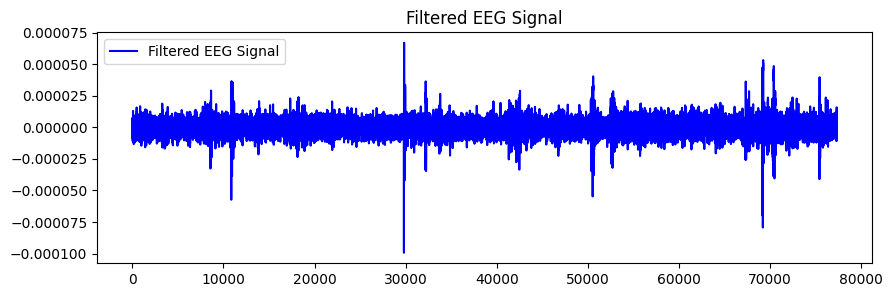

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S21 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


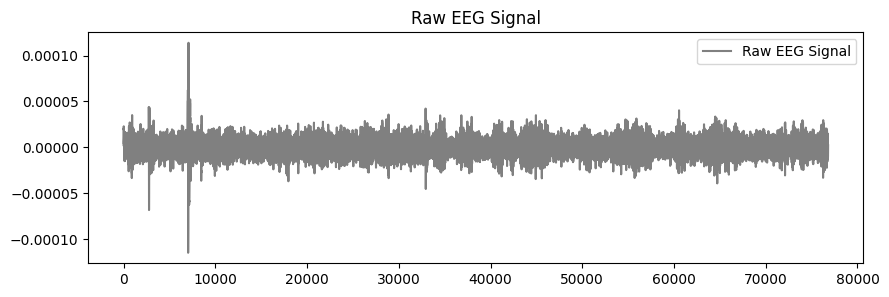

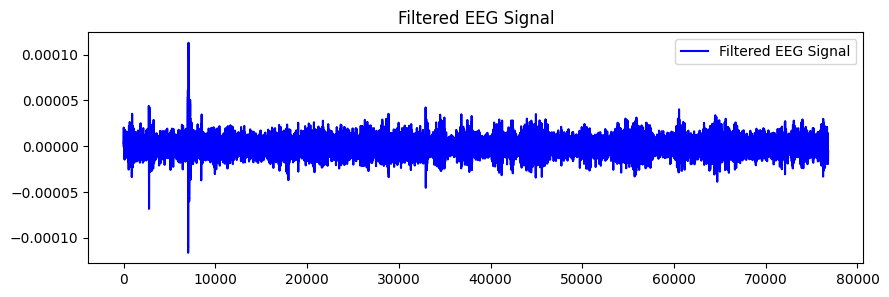

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S32 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...


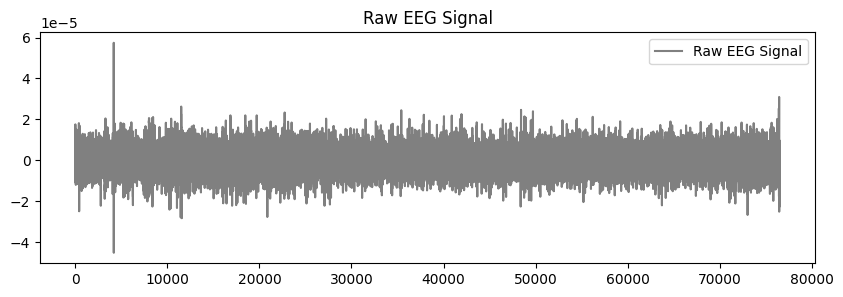

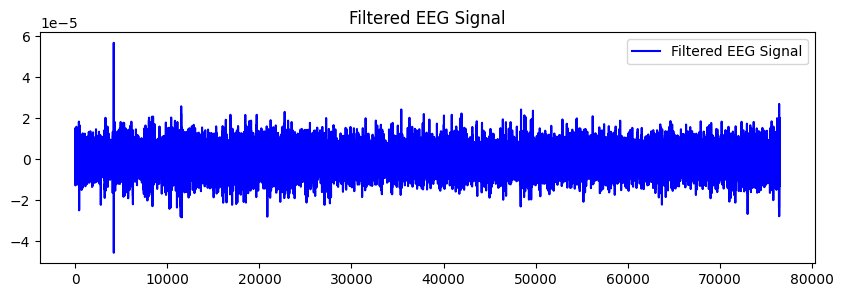

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S17 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...


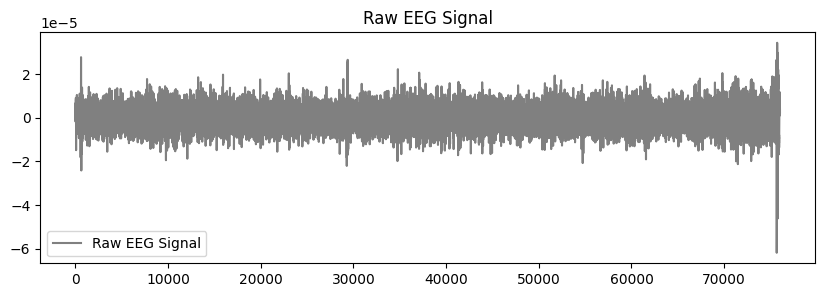

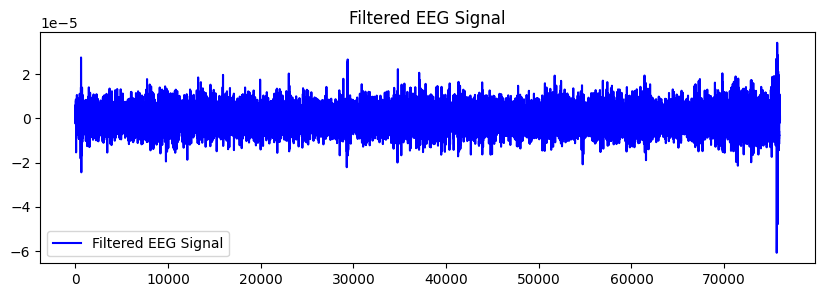

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


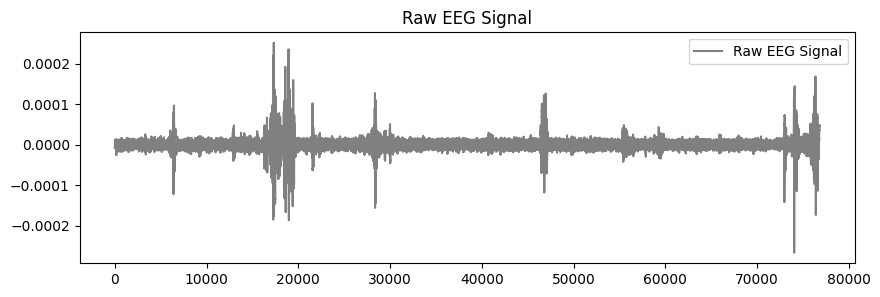

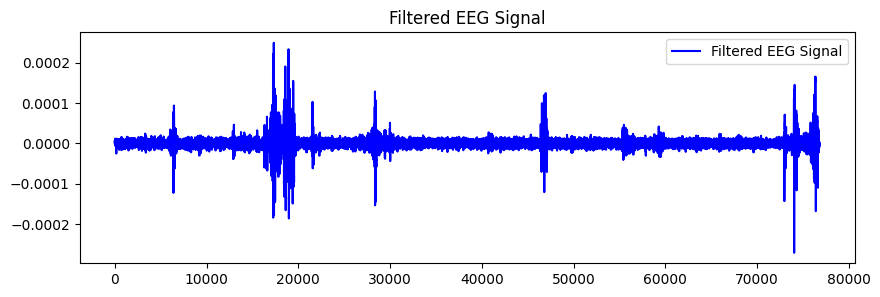

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S2 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76031  =      0.000 ...   296.996 secs...


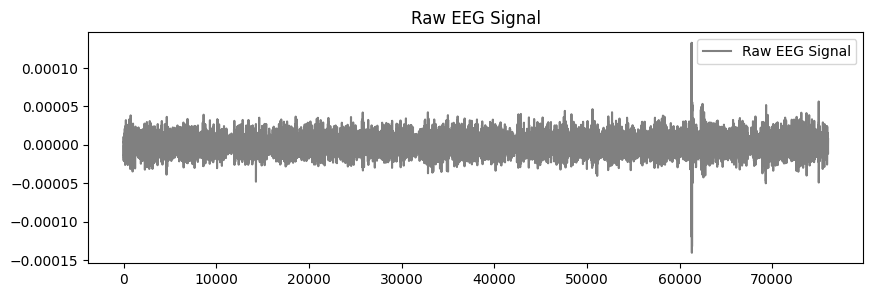

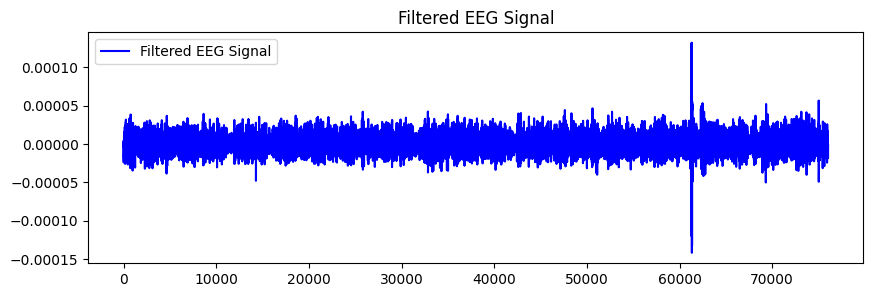

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S5 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


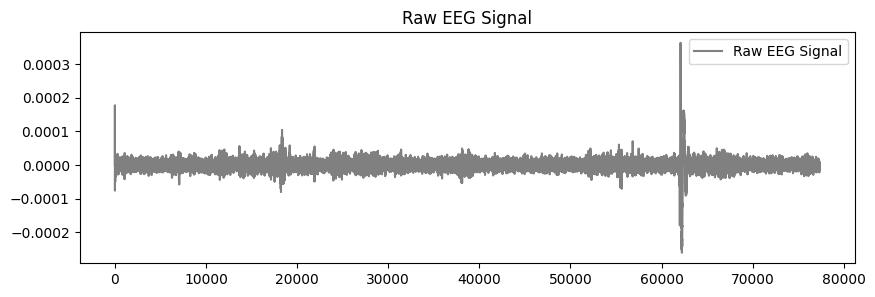

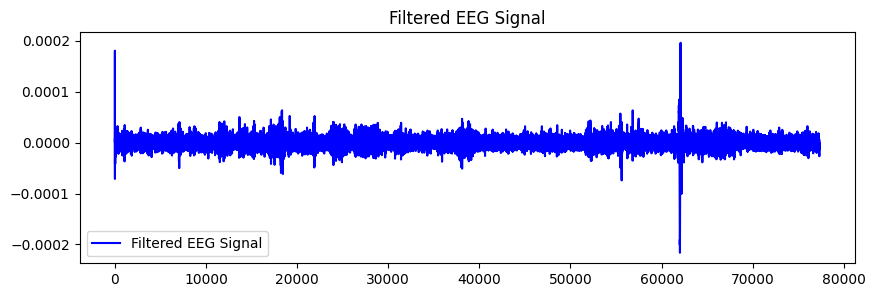

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S34 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76287  =      0.000 ...   297.996 secs...


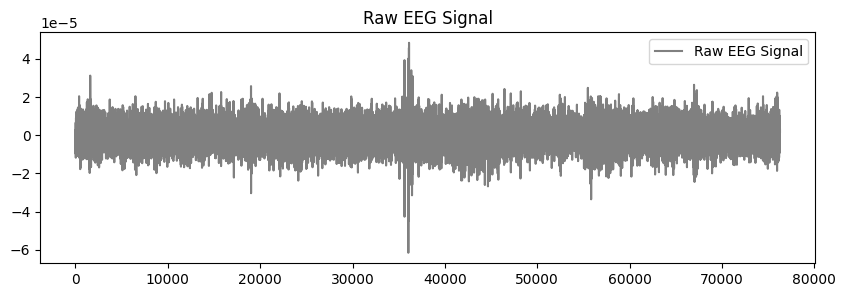

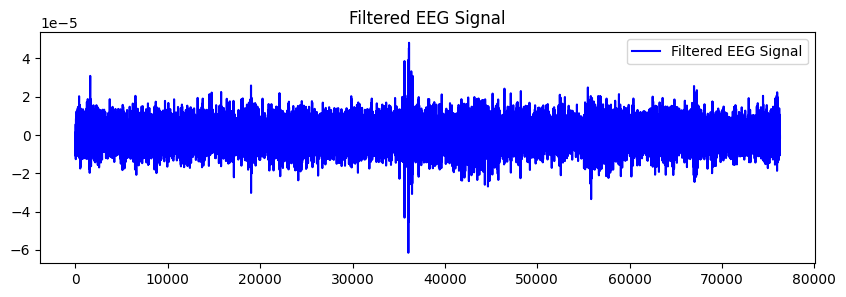

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S27 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


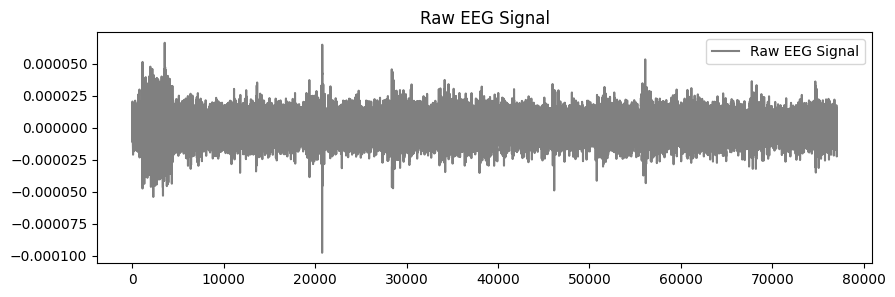

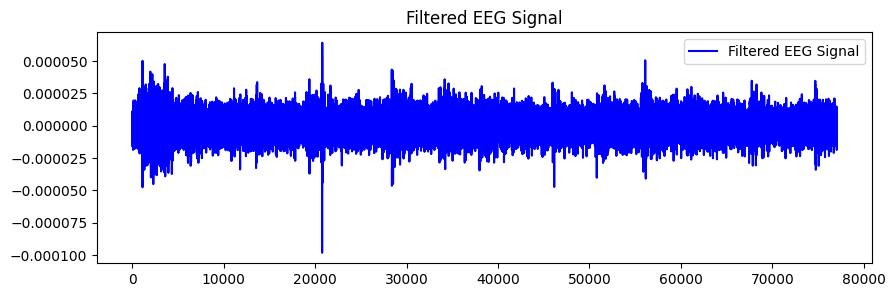

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S14 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


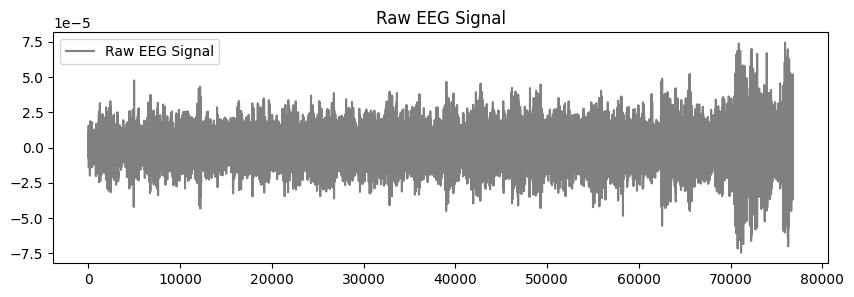

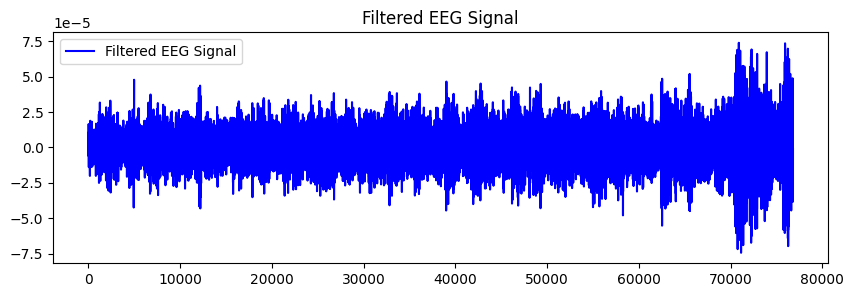

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S20 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...


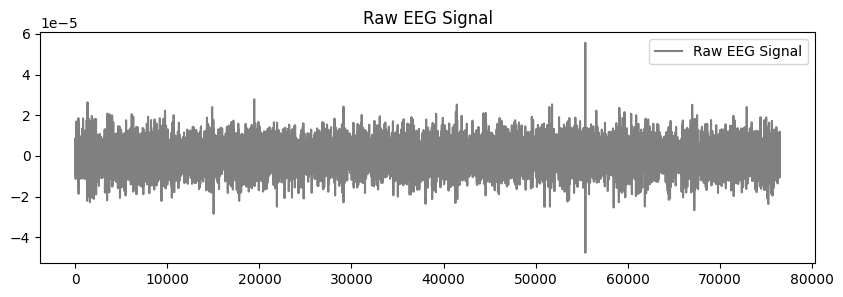

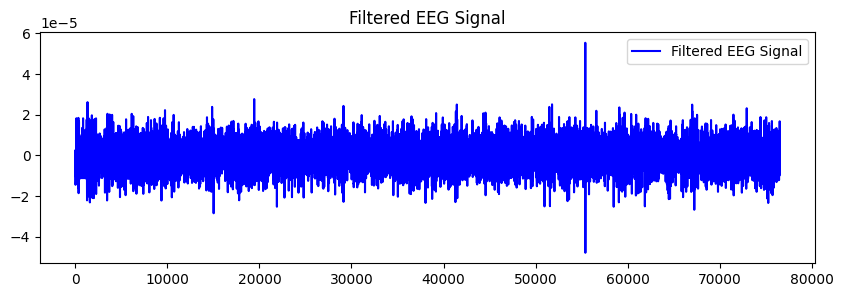

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S24 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


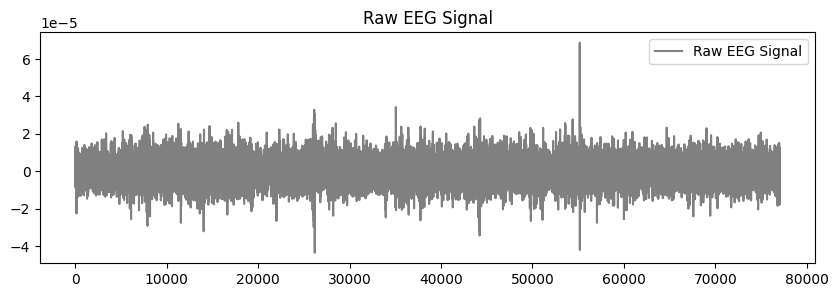

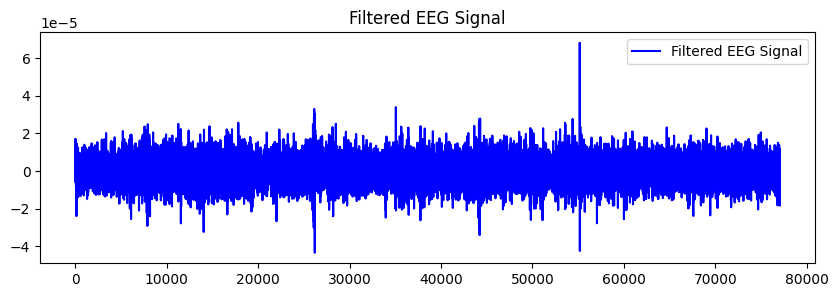

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S1 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77567  =      0.000 ...   302.996 secs...


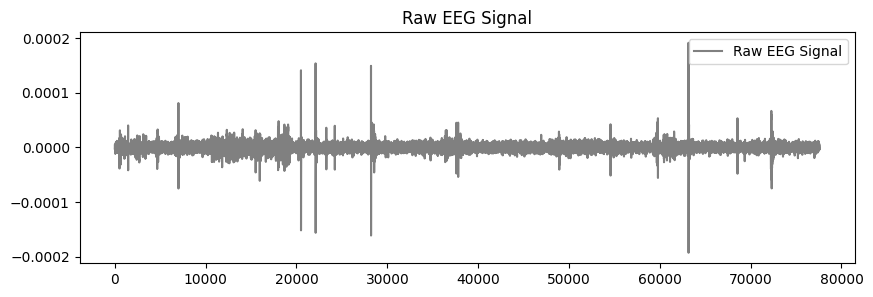

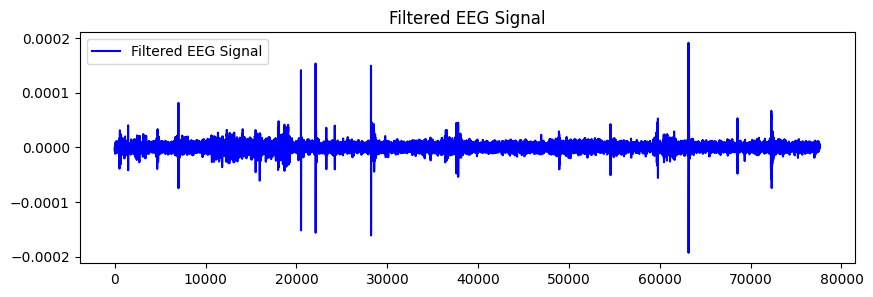

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S29 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


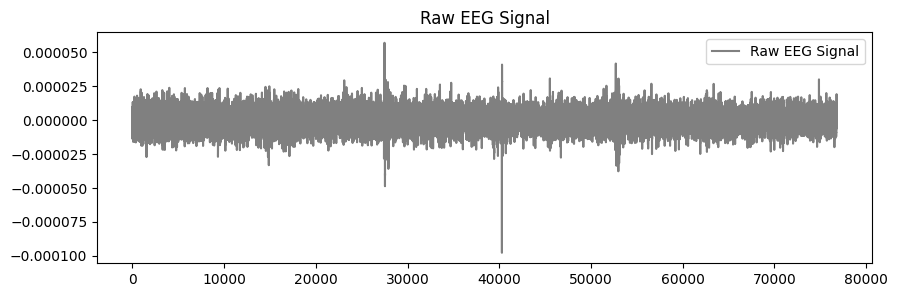

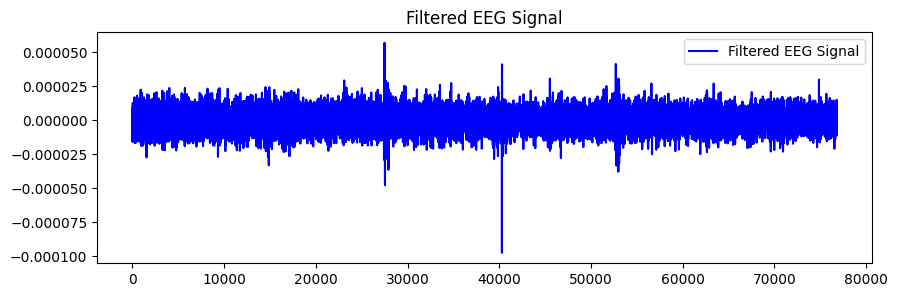

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD_S11_EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...


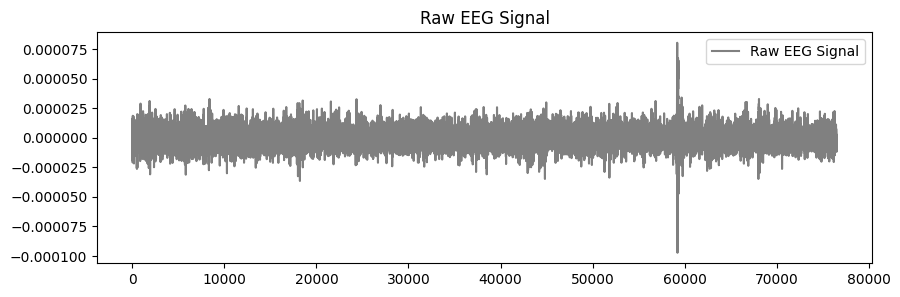

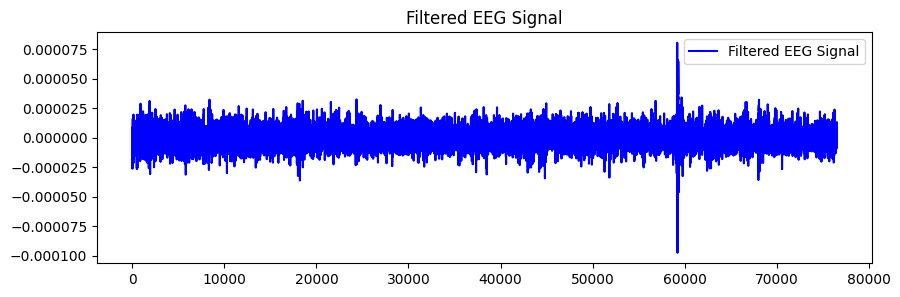

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S10 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


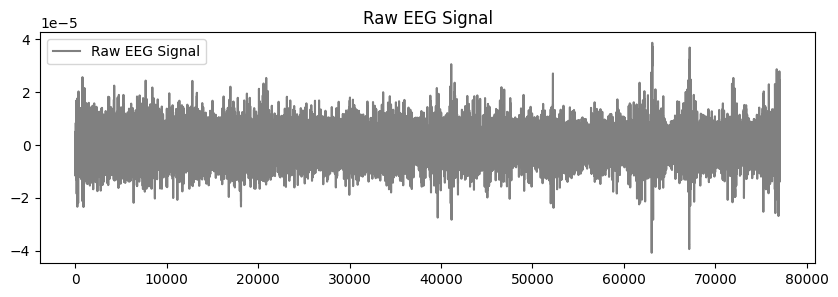

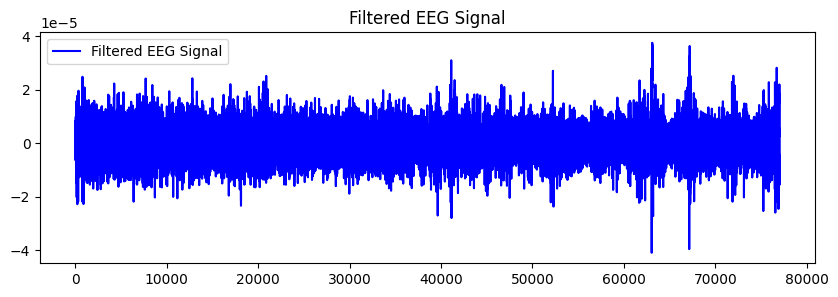

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S23 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77567  =      0.000 ...   302.996 secs...


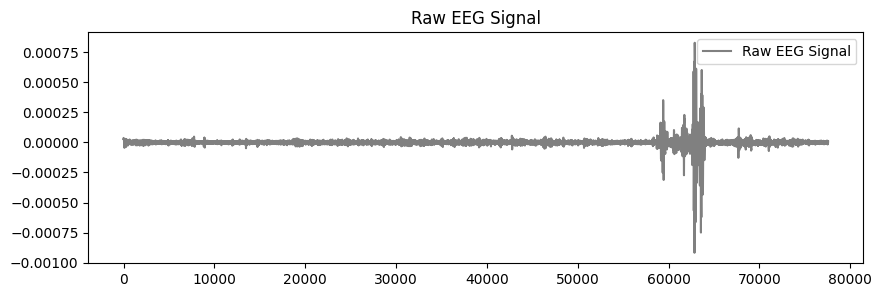

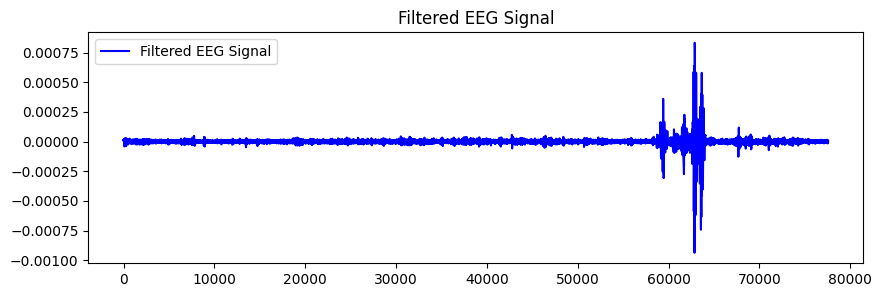

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S25 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


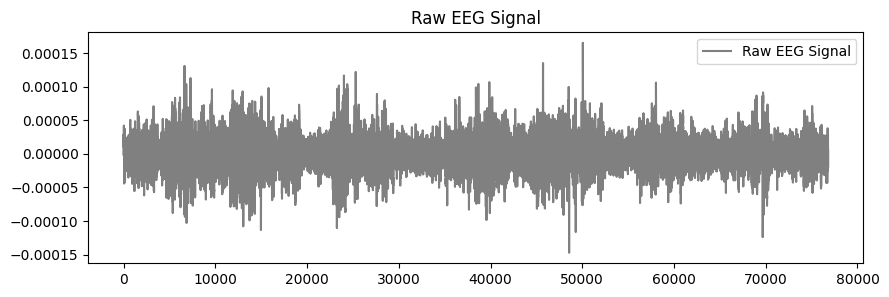

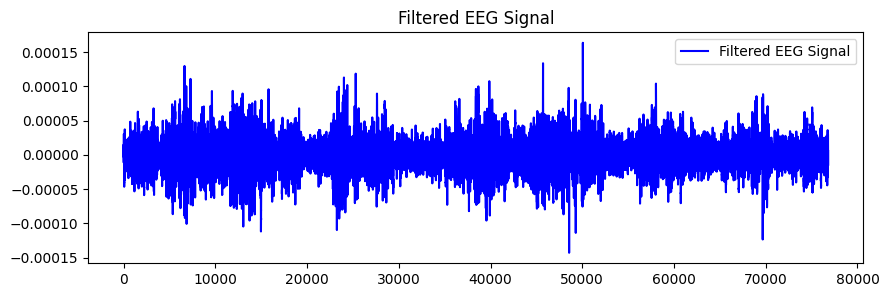

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S30 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 61695  =      0.000 ...   240.996 secs...


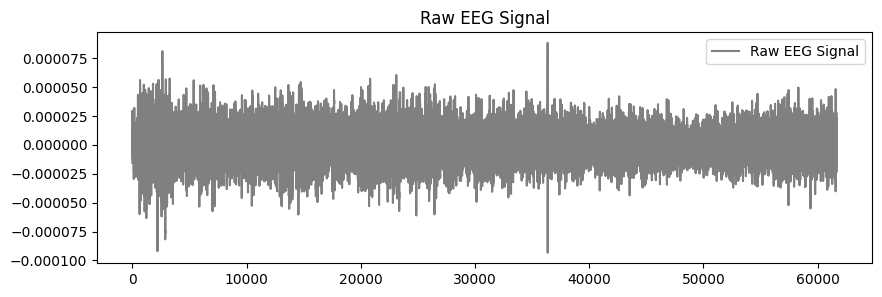

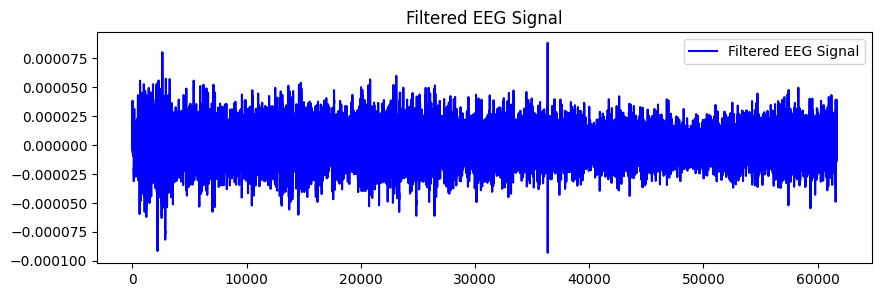

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S15 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


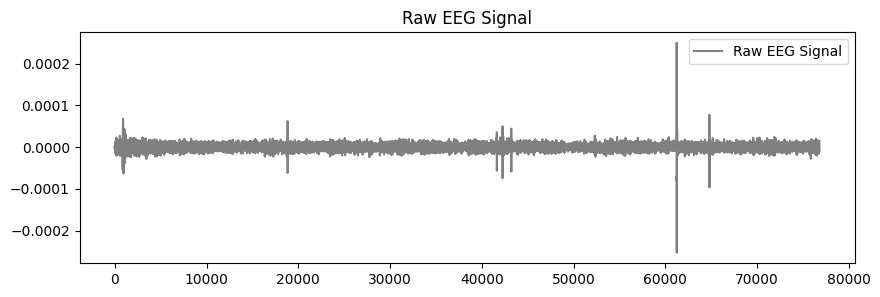

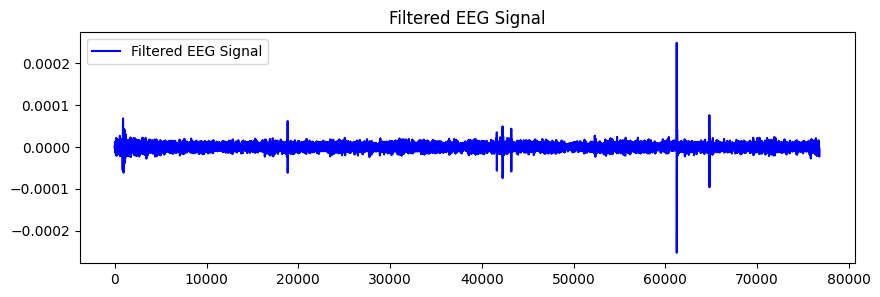

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S9 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


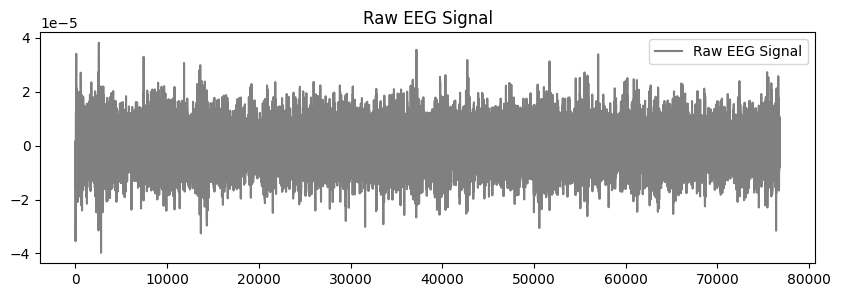

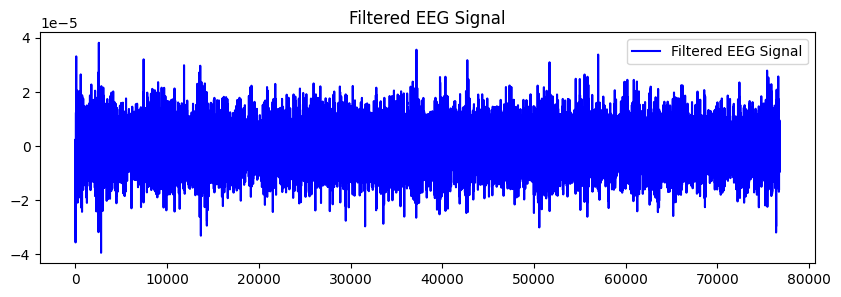

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S28 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...


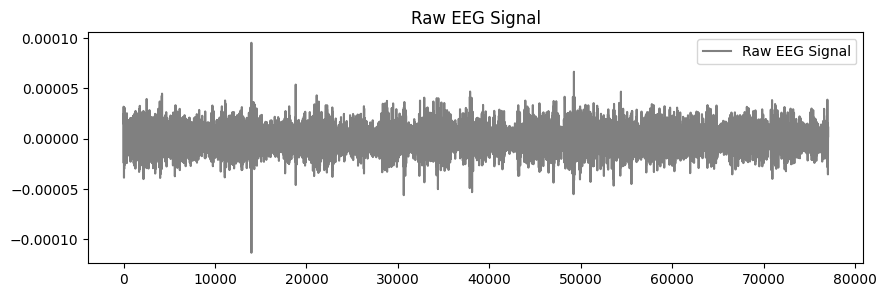

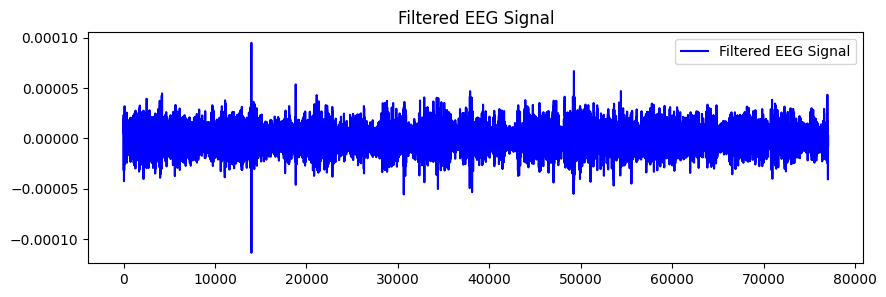

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S26 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


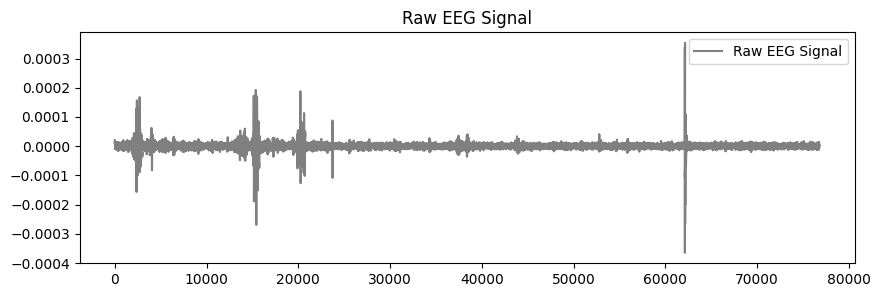

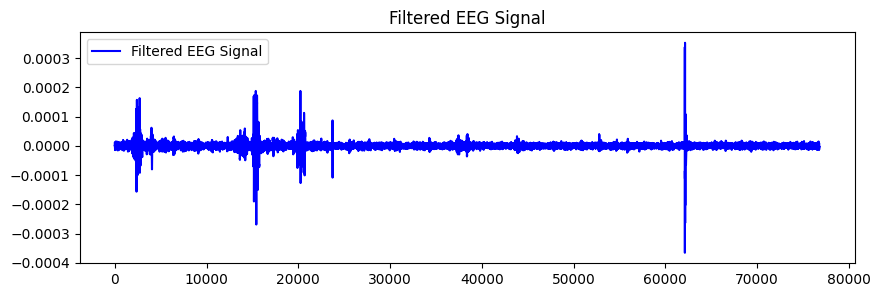

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76543  =      0.000 ...   298.996 secs...


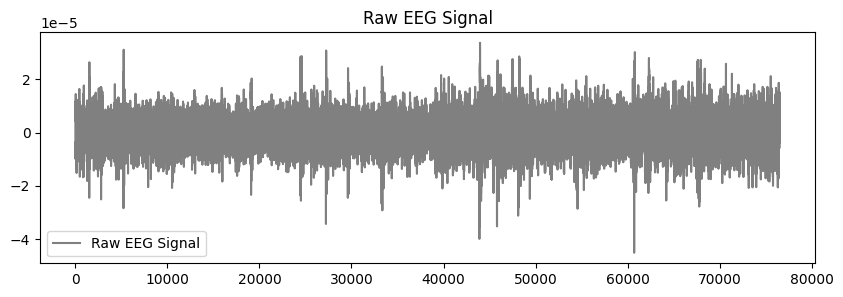

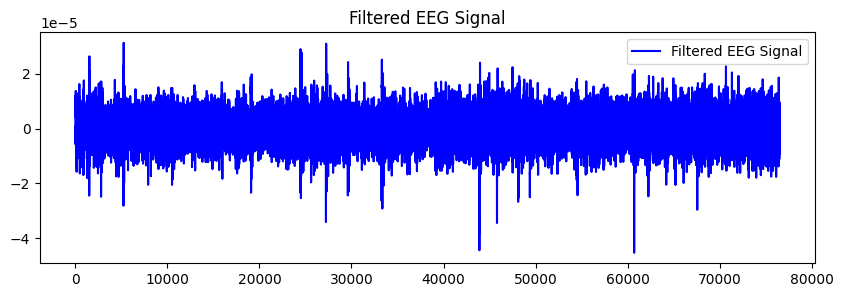

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S13 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


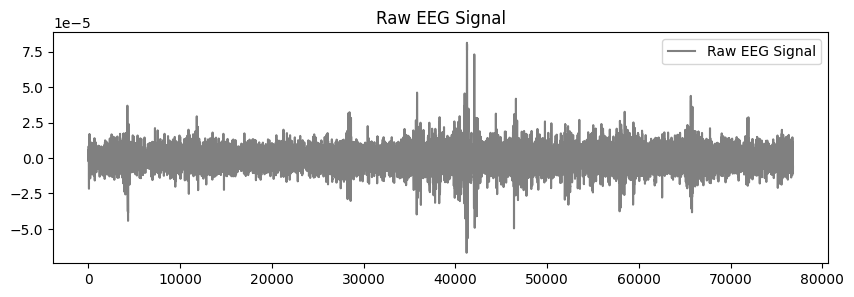

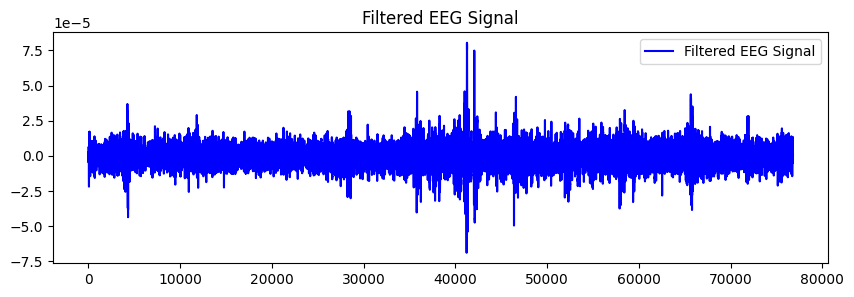

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S18 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...


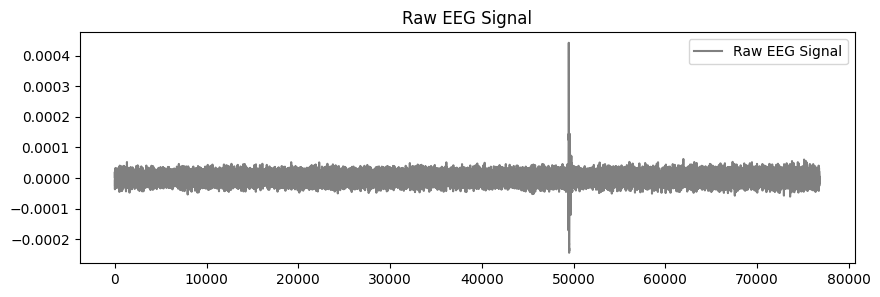

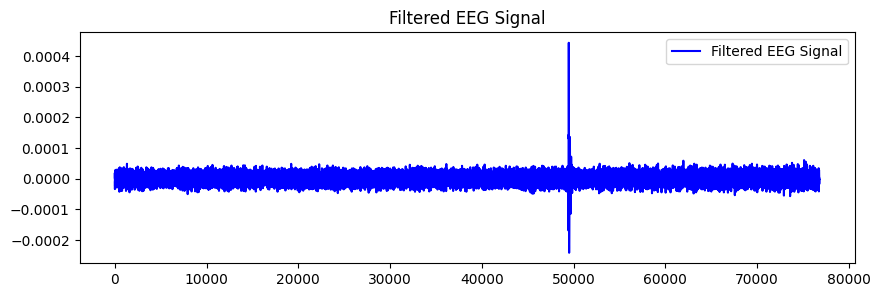

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S33 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76287  =      0.000 ...   297.996 secs...


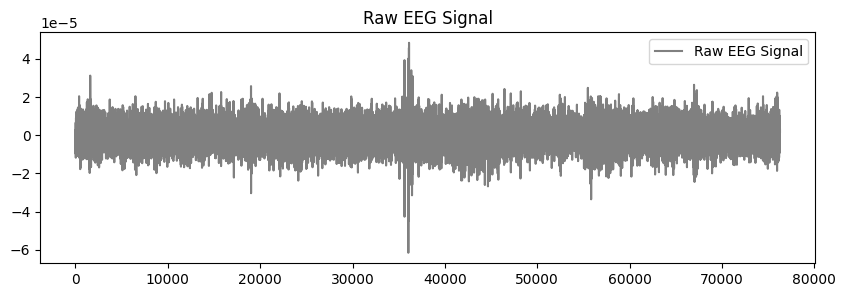

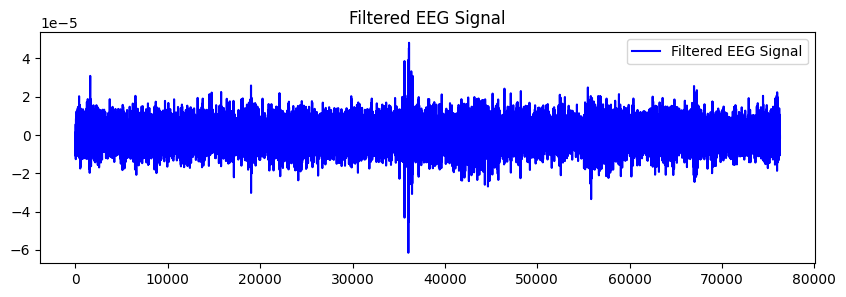

Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/MEC/MDD S6 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...


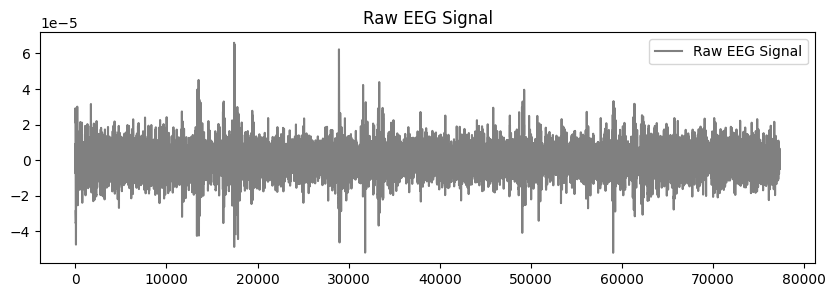

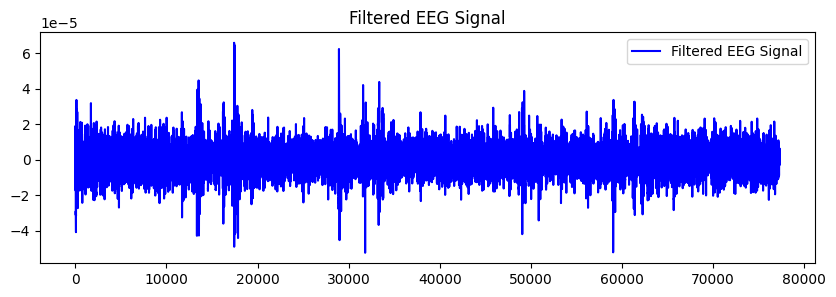

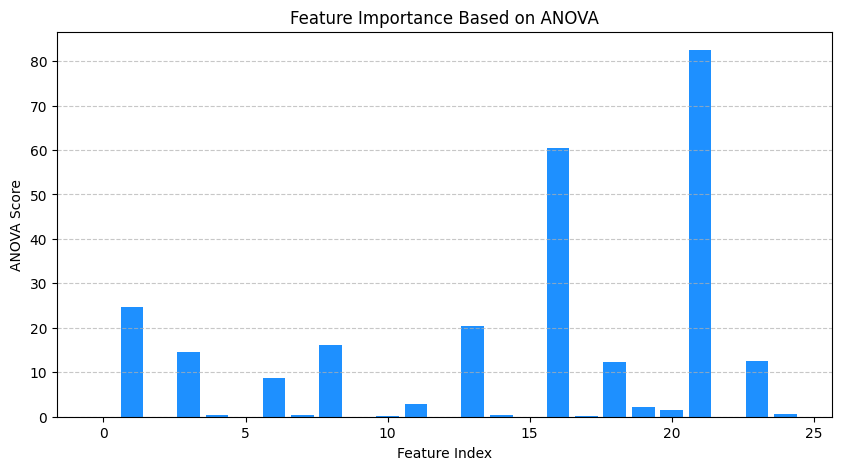

✅ Random Forest Accuracy: 96.19%
✅ SVM Accuracy: 53.33%
✅ KNN Accuracy: 90.48%
✅ XGBoost Accuracy: 97.14%
[LightGBM] [Info] Number of positive: 220, number of negative: 197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3488
[LightGBM] [Info] Number of data points in the train set: 417, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527578 -> initscore=0.110424
[LightGBM] [Info] Start training from score 0.110424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Extra Trees Accuracy: 99.05%
[LightGBM] [Info] Number of positive: 220, number of negative: 197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3488
[LightGBM] [Info] Number of data points in the train set: 417, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527578 -> initscore=0.110424
[LightGBM] [Info] Start training from score 0.110424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

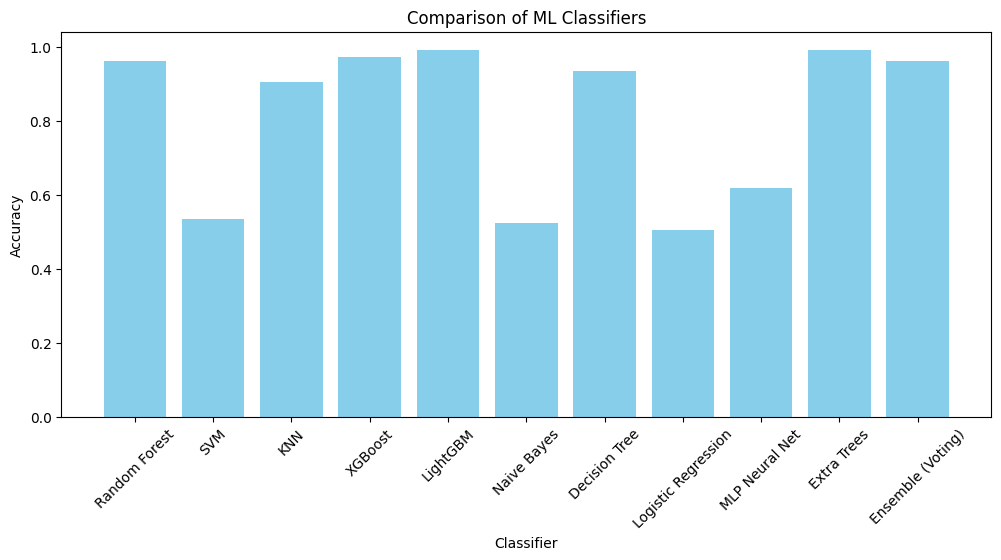

In [4]:
import os
import numpy as np
import mne
import pywt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import f_classif, SelectKBest
import pandas as pd

# Define dataset path
dataset_path = "/kaggle/input/mdd-dataset/MDD Dataset"
folders = ["HEC", "MEC"]  # HEC -> Healthy, MEC -> Depressed

# Selected wavelets
wavelets = ["db2", "db3", "db4", "db5", "db6", "sym3", "sym4", "sym5", "sym6"]

# Bandpass filter for EEG data
def bandpass_filter(signal, lowcut=1.0, highcut=50.0, fs=256, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Function to extract wavelet coefficients
def extract_wavelet_bands(eeg_signal, wavelet, level=5):
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)
    return coeffs[-5:]  # Extract delta, theta, alpha, beta, gamma

# Function to extract statistical features
def extract_features(sub_bands):
    features = []
    for band in sub_bands:
        mean_val = np.mean(band)
        std_val = np.std(band)
        skewness = stats.skew(band)
        kurtosis = stats.kurtosis(band)
        entropy_val = -np.sum(band * np.log2(np.abs(band) + 1e-10))
        features.extend([mean_val, std_val, skewness, kurtosis, entropy_val])
    return features

# Prepare dataset
X, y = [], []

for label, folder in enumerate(folders):  # HEC -> 0, MEC -> 1
    folder_path = os.path.join(dataset_path, folder)
    
    for file in os.listdir(folder_path):
        if file.endswith(".edf"):
            file_path = os.path.join(folder_path, file)
            raw = mne.io.read_raw_edf(file_path, preload=True)
            eeg_data = raw.get_data()
            eeg_signal = eeg_data[0]  # Extract first channel
            
            # Plot Raw EEG signal
            plt.figure(figsize=(10, 3))
            plt.plot(eeg_signal, label="Raw EEG Signal", color='gray')
            plt.title("Raw EEG Signal")
            plt.legend()
            plt.show()
            
            # Apply bandpass filter
            filtered_signal = bandpass_filter(eeg_signal)
            
            # Plot Filtered EEG signal
            plt.figure(figsize=(10, 3))
            plt.plot(filtered_signal, label="Filtered EEG Signal", color='blue')
            plt.title("Filtered EEG Signal")
            plt.legend()
            plt.show()
            
            # Extract features
            for wavelet in wavelets:
                sub_bands = extract_wavelet_bands(filtered_signal, wavelet)
                features = extract_features(sub_bands)
                X.append(features)
                y.append(label)
                
# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Perform ANOVA to select best features
selector = SelectKBest(score_func=f_classif, k='all')
X_selected = selector.fit_transform(X, y)
anova_scores = selector.scores_

# Plot ANOVA scores
plt.figure(figsize=(10, 5))
plt.bar(range(len(anova_scores)), anova_scores, color='dodgerblue')
plt.xlabel("Feature Index")
plt.ylabel("ANOVA Score")
plt.title("Feature Importance Based on ANOVA")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "MLP Neural Net": MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=500),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
}

# Ensemble Model (Voting Classifier)
ensemble_model = VotingClassifier(
    estimators=[('rf', classifiers["Random Forest"]), 
                ('svm', classifiers["SVM"]), 
                ('xgb', classifiers["XGBoost"]), 
                ('lgbm', classifiers["LightGBM"]),
                ('mlp', classifiers["MLP Neural Net"])],
    voting='hard'
)
classifiers["Ensemble (Voting)"] = ensemble_model

# Train & evaluate classifiers
accuracies = {}

for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies[clf_name] = acc
    print(f"✅ {clf_name} Accuracy: {acc * 100:.2f}%")

# Create a DataFrame for accuracy comparison
accuracy_df = pd.DataFrame(list(accuracies.items()), columns=["Classifier", "Accuracy"])
print(accuracy_df)

# Plot classifier accuracy comparison
plt.figure(figsize=(12, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Comparison of ML Classifiers")
plt.xticks(rotation=45)
plt.show()


In [ ]:
import os
import numpy as np
import mne
import pywt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import f_classif, SelectKBest

# Define dataset path
dataset_path = "/kaggle/input/mdd-dataset/MDD Dataset"
folders = ["HEC", "MEC"]  # HEC -> Healthy, MEC -> Depressed

# Selected wavelets
wavelets = ["db2", "db3", "db4", "db5", "sym2", "sym3", "sym4", "sym5","coif2", "coif3", "coif5","bior3.5", "bior4.4", "bior6.8"]

# Function to extract wavelet coefficients
def extract_wavelet_bands(eeg_signal, wavelet, level=5):
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)
    return coeffs[-5:]  # Extract Delta, Theta, Alpha, Beta, Gamma bands

# Function to extract statistical features
def extract_features(sub_bands):
    features = []
    stats_functions = {
        'Mean': np.mean, 'Std': np.std, 'Median': np.median, 'IQR': lambda x: np.percentile(x, 75) - np.percentile(x, 25),
        'Skewness': stats.skew, 'Kurtosis': stats.kurtosis, 'CV': lambda x: np.std(x) / np.mean(x), 'Energy': lambda x: np.sum(np.square(x))
    }
    
    for band in sub_bands:
        for stat_func in stats_functions.values():
            features.append(stat_func(band))
    
    return features

# Store results
wavelet_accuracies = {}
anova_scores_dict = {}

# Loop over wavelets
for wavelet in wavelets:
    print(f"Processing wavelet: {wavelet}")
    X, y = [], []

    for label, folder in enumerate(folders):
        folder_path = os.path.join(dataset_path, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".edf"):
                raw = mne.io.read_raw_edf(os.path.join(folder_path, file), preload=True)
                eeg_signal = raw.get_data()[0]
                sub_bands = extract_wavelet_bands(eeg_signal, wavelet)
                features = extract_features(sub_bands)
                X.append(features)
                y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    # Feature Selection using ANOVA
    selector = SelectKBest(score_func=f_classif, k='all')
    X_selected = selector.fit_transform(X, y)
    anova_scores_dict[wavelet] = selector.scores_
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Define classifiers
    classifiers = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(kernel='rbf', random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        "LightGBM": LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=200, max_depth=-1, random_state=42),
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "MLP Neural Net": MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000),
        "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
    }

    accuracies = {}
    
    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies[clf_name] = round(acc, 2)  # Keeping only 2 decimal places
    
    wavelet_accuracies[wavelet] = accuracies

# Convert accuracy results to DataFrame
accuracy_df = pd.DataFrame(wavelet_accuracies).T
print("\nFinal Accuracy Table:")
print(accuracy_df)

# Adjusted Table Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=accuracy_df.values, colLabels=accuracy_df.columns, rowLabels=accuracy_df.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.5, 1.5)  # Increased width
plt.title("Accuracy Table for Wavelets Across ML Classifiers")
plt.show()

# Accuracy Comparison Across ML Classifiers
plt.figure(figsize=(10, 5))
for model in accuracy_df.columns:
    plt.plot(accuracy_df.index, accuracy_df[model], marker='o', label=model)
plt.xlabel("Wavelet")
plt.ylabel("Accuracy")
plt.title("Accuracy Trend of ML Models Across Wavelets")
plt.legend(title="ML Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()


Processing wavelet: db2
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S27 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Datas

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77311  =      0.000 ...   301.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S9 EC.edf...
E

# **Denoising and nonlinear feature**

Processing wavelet: db2
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S27 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Datas

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [32 42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 24, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 748
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
E

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 24, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 779
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
E

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
E

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
E

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 24, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 812
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
E

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 24, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 819
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
E

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 24, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
E

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 24, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 822
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
E

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
E

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
E

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 24, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 779
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S16 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 74751  =      0.000 ...   291.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S14 EC.edf...
E

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [42] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


[LightGBM] [Info] Number of positive: 24, number of negative: 22
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 823
[LightGBM] [Info] Number of data points in the train set: 46, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.521739 -> initscore=0.087011
[LightGBM] [Info] Start training from score 0.087011
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Processing wavelet: bior6.8
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S27 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S7 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 91135  =      0.000 ...   355.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S19 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 76799  =      0.000 ...   299.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD Dataset/HEC/H S3 EC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 77055  =      0.000 ...   300.996 secs...
Extracting EDF parameters from /kaggle/input/mdd-dataset/MDD D

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Final Accuracy Table:
         Random Forest   SVM   KNN  XGBoost  LightGBM  Naive Bayes  \
db2               0.83  0.83  0.92     1.00      0.75         0.58   
db3               0.67  0.75  0.67     0.92      0.83         0.50   
db4               0.67  0.50  0.75     0.92      0.75         0.50   
db5               0.83  0.83  0.75     0.83      0.75         0.58   
sym2              0.83  0.83  0.92     1.00      0.75         0.58   
sym3              0.67  0.75  0.67     0.83      0.83         0.50   
sym4              0.83  0.75  0.67     0.83      0.92         0.75   
sym5              0.92  0.50  1.00     0.92      0.92         0.50   
coif2             0.75  0.92  0.83     0.58      0.58         0.58   
coif3             0.92  1.00  0.67     0.83      0.83         0.50   
coif5             0.83  0.50  0.67     0.83      0.75         0.42   
bior3.5           0.83  0.50  0.75     0.58      0.58         0.58   
bior4.4           0.92  0.92  0.75     0.83      0.75         0.58 

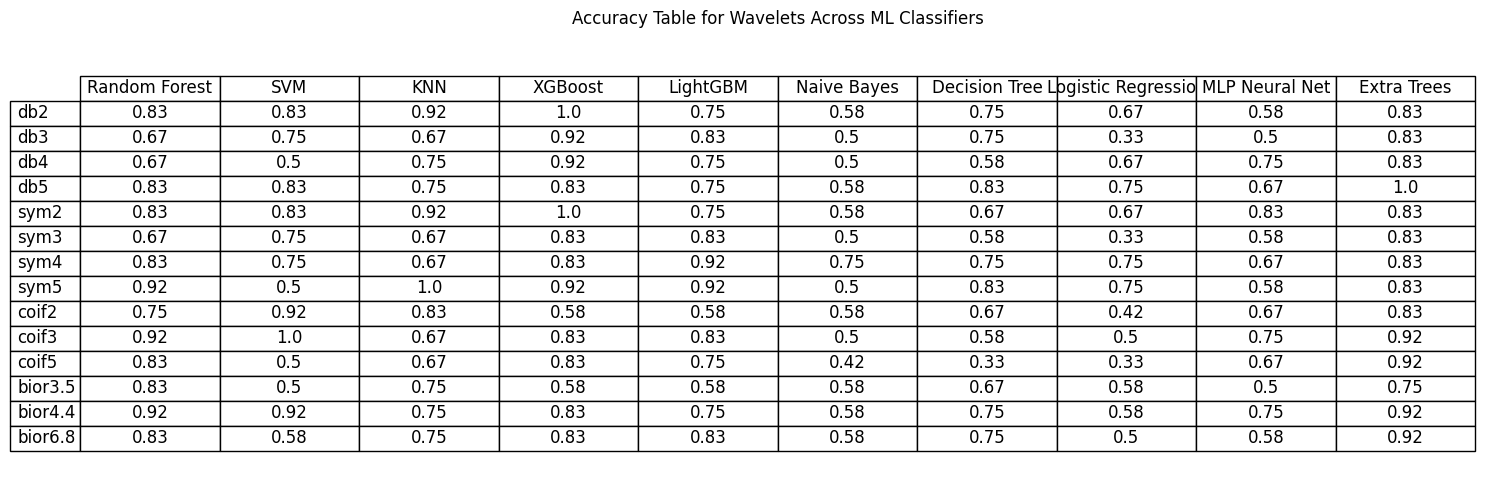

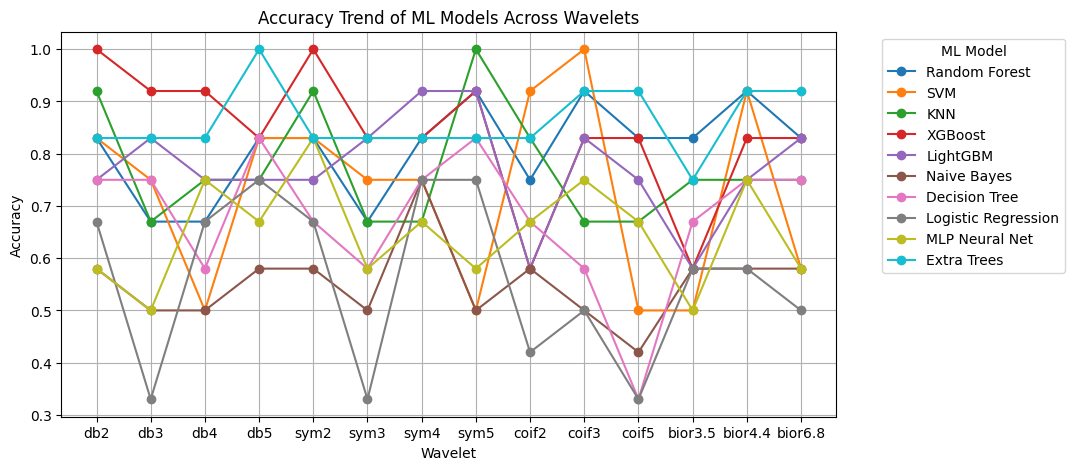

In [8]:
import os
import numpy as np
import mne
import pywt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import f_classif, SelectKBest
import antropy as ant

# Define dataset path
dataset_path = "/kaggle/input/mdd-dataset/MDD Dataset"
folders = ["HEC", "MEC"]  # HEC -> Healthy, MEC -> Depressed

# Selected wavelets
wavelets = ["db2", "db3", "db4", "db5", "sym2", "sym3", "sym4", "sym5","coif2", "coif3", "coif5","bior3.5", "bior4.4", "bior6.8"]

# Function to denoise EEG signals using wavelet thresholding
def wavelet_denoising(signal, wavelet='db4', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))
    coeffs = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    return pywt.waverec(coeffs, wavelet)

# Function to extract wavelet coefficients
def extract_wavelet_bands(eeg_signal, wavelet, level=5):
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)
    return coeffs[-5:]  # Extract Delta, Theta, Alpha, Beta, Gamma bands

# Function to extract features
def extract_features(sub_bands):
    features = []
    stats_functions = {
        'Mean': np.mean, 'Std': np.std, 'Median': np.median, 'IQR': lambda x: np.percentile(x, 75) - np.percentile(x, 25),
        'Skewness': stats.skew, 'Kurtosis': stats.kurtosis, 'CV': lambda x: np.std(x) / np.mean(x), 'Energy': lambda x: np.sum(np.square(x))
    }
    nonlinear_features = {'ApEn': ant.app_entropy, 'SampEn': ant.sample_entropy}
    
    for band in sub_bands:
        for stat_func in stats_functions.values():
            features.append(stat_func(band))
        for nl_func in nonlinear_features.values():
            features.append(nl_func(band))
    
    return features

# Store results
wavelet_accuracies = {}
anova_scores_dict = {}

# Loop over wavelets
for wavelet in wavelets:
    print(f"Processing wavelet: {wavelet}")
    X, y = [], []

    for label, folder in enumerate(folders):
        folder_path = os.path.join(dataset_path, folder)
        for file in os.listdir(folder_path):
            if file.endswith(".edf"):
                raw = mne.io.read_raw_edf(os.path.join(folder_path, file), preload=True)
                eeg_signal = raw.get_data()[0]
                denoised_signal = wavelet_denoising(eeg_signal, wavelet)
                sub_bands = extract_wavelet_bands(denoised_signal, wavelet)
                features = extract_features(sub_bands)
                X.append(features)
                y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    
    # Feature Selection using ANOVA
    selector = SelectKBest(score_func=f_classif, k='all')
    X_selected = selector.fit_transform(X, y)
    anova_scores_dict[wavelet] = selector.scores_
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Define classifiers
    classifiers = {
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
        "SVM": SVC(kernel='rbf', random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        "LightGBM": LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=200, max_depth=-1, random_state=42),
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "MLP Neural Net": MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=1000),
        "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=42)
    }

    accuracies = {}
    
    for clf_name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies[clf_name] = round(acc, 2)  # Keeping only 2 decimal places
    
    wavelet_accuracies[wavelet] = accuracies

# Convert accuracy results to DataFrame
accuracy_df = pd.DataFrame(wavelet_accuracies).T
print("\nFinal Accuracy Table:")
print(accuracy_df)

# Adjusted Table Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=accuracy_df.values, colLabels=accuracy_df.columns, rowLabels=accuracy_df.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)

table.scale(1.5, 1.5)  # Increased width
plt.title("Accuracy Table for Wavelets Across ML Classifiers")
plt.show()

# Accuracy Comparison Across ML Classifiers
plt.figure(figsize=(10, 5))
for model in accuracy_df.columns:
    plt.plot(accuracy_df.index, accuracy_df[model], marker='o', label=model)
plt.xlabel("Wavelet")
plt.ylabel("Accuracy")
plt.title("Accuracy Trend of ML Models Across Wavelets")
plt.legend(title="ML Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

<Figure size 1400x600 with 0 Axes>

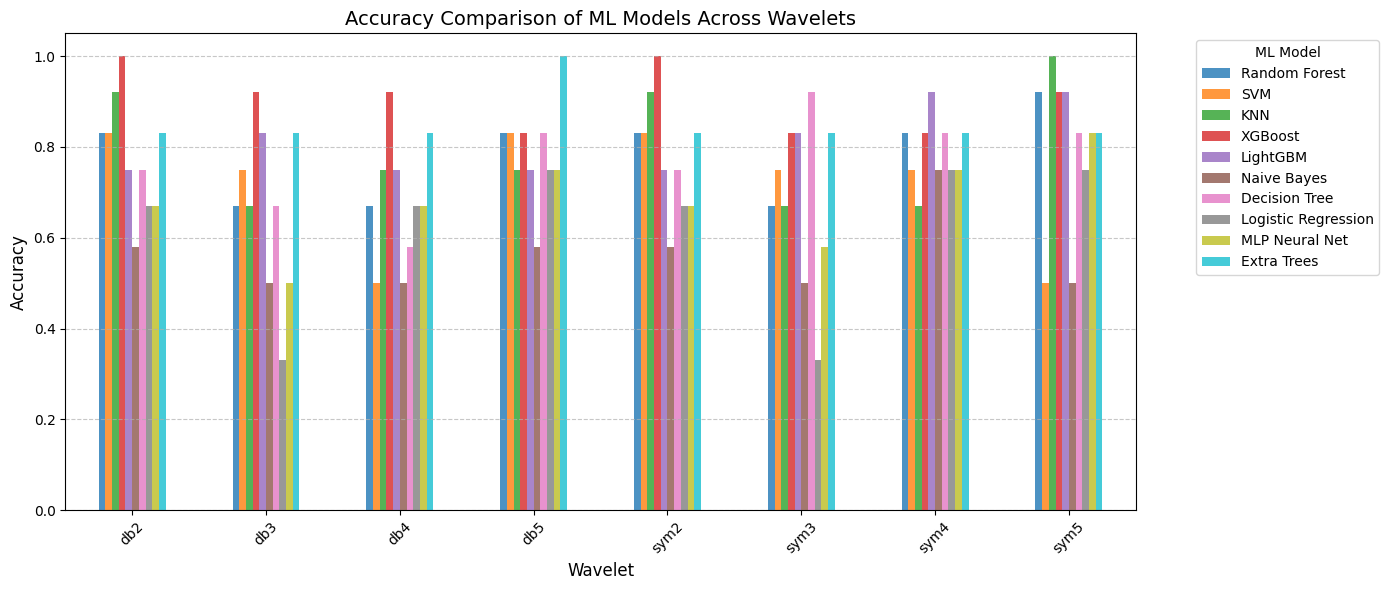

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the accuracy data
data = {
    "Random Forest": [0.83, 0.67, 0.67, 0.83, 0.83, 0.67, 0.83, 0.92],
    "SVM": [0.83, 0.75, 0.50, 0.83, 0.83, 0.75, 0.75, 0.50],
    "KNN": [0.92, 0.67, 0.75, 0.75, 0.92, 0.67, 0.67, 1.00],
    "XGBoost": [1.00, 0.92, 0.92, 0.83, 1.00, 0.83, 0.83, 0.92],
    "LightGBM": [0.75, 0.83, 0.75, 0.75, 0.75, 0.83, 0.92, 0.92],
    "Naive Bayes": [0.58, 0.50, 0.50, 0.58, 0.58, 0.50, 0.75, 0.50],
    "Decision Tree": [0.75, 0.67, 0.58, 0.83, 0.75, 0.92, 0.83, 0.83],
    "Logistic Regression": [0.67, 0.33, 0.67, 0.75, 0.67, 0.33, 0.75, 0.75],
    "MLP Neural Net": [0.67, 0.50, 0.67, 0.75, 0.67, 0.58, 0.75, 0.83],
    "Extra Trees": [0.83, 0.83, 0.83, 1.00, 0.83, 0.83, 0.83, 0.83]
}

# Define wavelet names
wavelets = ["db2", "db3", "db4", "db5", "sym2", "sym3", "sym4", "sym5"]

# Convert dictionary to DataFrame
df = pd.DataFrame(data, index=wavelets)

# Plot the bar graph
plt.figure(figsize=(14, 6))
df.plot(kind="bar", figsize=(14, 6), colormap="tab10", alpha=0.8)

# Formatting the plot
plt.xlabel("Wavelet", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy Comparison of ML Models Across Wavelets", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="ML Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()
